# Distribution of Aggregate Benefits

## Setup

In [2]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))
suppressWarnings(suppressMessages(library(boot)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select
theme_set(theme_grey())

In [3]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6, scipen=8)

In [4]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="dccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf) %>%
    mutate(fips = fips_code) %>% select(-fips_code)
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

In [5]:
db_path = "../../../data/hot.db"
trips_raw = load_table(db_path, "trips_linked")
sp_vol = load_table(db_path, "sp_vol")
tt = load_table(db_path, "travel_times")

In [13]:
reliability = suppressMessages(read_csv("../../data/benefits/expected_reliability_savings.csv"))
trip_length_lookup = suppressMessages(read_csv("../../data/milepost_lookups/trip_length_lookup.csv"))
m_est_values = suppressMessages(read_csv("../../data/benefits/est_vot_vor_elast.csv"))

In [7]:
trips.2pct = load_table(db_path, "trips_2pct", 
                        c(tag_id="c", acct="c", plate="c", id="c", zip="c")) %>% 
    execute

Warning message:
“Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two.”Warning message:
“11 parsing failures.
   row col               expected actual         file
 37249 zip a double               V3W7X4 literal data
 37787 zip no trailing characters LY     literal data
 46162 zip a double               V3W7X4 literal data
123282 zip a double               V3W7X4 literal data
132178 zip a double               V3W7X4 literal data
...... ... ...................... ...... ............
See problems(...) for more details.
”

In [14]:
m_est_values %>%
    gather(param, est) %>%
    group_by(param) %>%
    group_modify(~ as.data.frame(t(quantile(.$est, c(0.025, 0.5, 0.975)))))

VOT = median(m_est_values$VOT)
VOR = median(m_est_values$VOR)

VOT_low  = quantile(m_est_values$VOT, 0.025)
VOT_high = quantile(m_est_values$VOT, 0.975)
VOR_low  = quantile(m_est_values$VOR, 0.025)
VOR_high = quantile(m_est_values$VOR, 0.975)

param,2.5%,50%,97.5%
<chr>,<dbl>,<dbl>,<dbl>
elasticity,-0.6662101,-0.6360605,-0.606677
VOR,24.0449975,26.4868615,28.923806
VOT,51.9279909,53.1824673,54.359109


In [297]:
fips_benefits = trips.2pct %>%
    filter(commercial == 0) %>%
    select(toll, entry_time, entry=entry_plaza, exit=exit_plaza, is_hov, id, fips, savings) %>%
    filter(!is.na(fips)) %>%
    mutate(date_time_1 = as_datetime(as.integer(entry_time/60)*60),
           date_time_5 = as_datetime(as.integer(entry_time/300)*300),
           tod = 100*hour(date_time_5) + minute(date_time_5),
           hour = hour(as_datetime(entry_time)),
           peak = (hour >= 5 & hour < 9) | (hour >= 15 & hour < 19),
           am_peak = hour >= 5 & hour < 9 & entry >= 13,
           pm_peak = hour >= 15 & hour < 19 & entry <= 12,
           rev_comm = (hour >= 5 & hour < 9 & entry <= 12) | (hour >= 15 & hour < 19 & entry >= 13),
           off_peak = hour >= 9 & hour < 15,
           occup_wgt = ifelse(is_hov, ifelse(peak, 3, 2), 1)) %>%
    left_join(reliability, by=c("tod", "entry", "exit")) %>%
    left_join(trip_length_lookup, by=c("entry", "exit")) %>%
    select(fips, is_hov, occup_wgt, id, toll, contains("peak"), rev_comm, trip_length, savings, reliability) %>%
    group_by(fips, is_hov) %>%
    summarize(trips = n(),
              users = n_distinct(id),
              revenue = sum(toll),
              am_peak_trips = sum(am_peak),
              pm_peak_trips = sum(pm_peak),
              rev_comm_trips = sum(rev_comm),
              off_peak_trips = sum(off_peak),
              vmt = sum(trip_length),
              savings = sum(savings*occup_wgt),
              reliability = sum(reliability*occup_wgt)) %>%
    arrange(fips, is_hov) %>%
    mutate(savings_benefit = VOT*savings,
           reliability_benefit = VOR*reliability,
           total_benefit = VOT*savings + VOR*reliability,
           net_benefit = total_benefit - revenue) %>%
    inner_join(acs %>%
            select(fips, county, county_name, tract, households, population, mean_inc, contains("race")) %>%
            mutate(tract = paste0("53", county, tract), county=county_name) %>%
            select(-county_name),
        by="fips")

In [298]:
head(fips_benefits)

fips,is_hov,trips,users,revenue,am_peak_trips,pm_peak_trips,rev_comm_trips,off_peak_trips,vmt,⋯,reliability_benefit,total_benefit,net_benefit,county,tract,households,population,mean_inc,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
530330001001,0,11,8,18.25,4,3,0,4,58.20,⋯,6.987896,30.94364,12.693643,King,53033000100,608,1265,170745.87,0.07667984,0.8774704
530330001001,1,2,1,0.00,0,0,2,0,9.43,⋯,4.698107,25.96666,25.966662,King,53033000100,608,1265,170745.87,0.07667984,0.8774704
530330001002,0,5,2,22.50,2,2,0,0,24.93,⋯,2.193333,29.36219,6.862187,King,53033000100,758,1534,59597.32,0.07692308,0.5013038
530330001002,1,7,5,0.00,0,3,1,3,63.03,⋯,29.463543,121.43819,121.438189,King,53033000100,758,1534,59597.32,0.07692308,0.5013038
530330001003,0,12,11,21.50,1,3,4,4,69.31,⋯,7.572667,42.71741,21.217414,King,53033000100,724,1817,80377.15,0.13538800,0.5976885
530330001004,0,20,14,66.75,5,4,6,4,122.30,⋯,13.831954,110.75552,44.005523,King,53033000100,1052,2270,42036.00,0.14052863,0.2854626


In [299]:
write_csv(fips_benefits, "../../data/benefits/fips_benefits.csv")

## Aggregate benefits

In [15]:
trip_counts = trips_raw %>%
    transmute(is_hov = coalesce(is_hov, toll == 0),
              toll = toll) %>%
    group_by(is_hov) %>%
    summarize(trips = n(),
              revenue = sum(toll, na.rm=T)) %>%
    execute

In [16]:
sov_trips = as.numeric(trip_counts[1,2])
hov_trips = as.numeric(trip_counts[2,2])
total_trips = sov_trips + hov_trips
sov_revenue = as.numeric(trip_counts[1,3])
hov_revenue = as.numeric(trip_counts[2,3])
total_revenue = sov_revenue + hov_revenue

In [74]:
compute_agg = function(VOT, VOR, HOV, avg=F) {
    fips_benefits %>%
        group_by(is_hov) %>%
        summarize(time_savings = sum(savings, na.rm=T)/sum(trips),
                  time_reliability = sum(reliability, na.rm=T)/sum(trips),
                  VOT_savings =         time_savings * VOT,
                  VOR_reliability = time_reliability * VOR,
                  total_benefit = VOT_savings + VOR_reliability,
                  revenue = sum(revenue)/sum(trips),
                  net_benefit = total_benefit - revenue) %>%
        mutate(multiplier = if_else(is_hov==1, hov_trips, sov_trips)) %>%
        mutate_at(vars(-is_hov, -multiplier), ~ . * (if (!avg) multiplier else 1)) %>%
        filter(is_hov %in% HOV) %>%
        select(-is_hov, -multiplier) %>%
        summarize_all(sum) %>%
        mutate_at(vars(-contains("time")), scales::dollar) %>%
        mutate_at(vars(contains("time")), if (!avg) scales::comma else function(x) as.character(round(60*x, 2)))
}

make_range_table = function(HOV, label) {
    cat(paste0("\n\n", label))
    bind_rows(
        compute_agg(VOT_low, VOR_low, HOV),
        compute_agg(VOT, VOR, HOV),
        compute_agg(VOT_high, VOR_high, HOV)
    ) %>%
    mutate(est=c("Low", "Median", "High"),
           VOT=scales::dollar(c(VOT_low, VOT, VOT_high)),
           VOR=scales::dollar(c(VOR_low, VOR, VOR_high))) %>%
    select(est, everything())
}


make_range_table(0, "SOV aggregate")
#make_range_table(1, "HOV")
#make_range_table(0:1, "TOTAL")



SOV aggregate

est,time_savings,time_reliability,VOT_savings,VOR_reliability,total_benefit,revenue,net_benefit,VOT,VOR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Low,"814,036","376,750","$42,271,235","$9,058,959","$51,330,193","$32,041,943","$19,288,250",$51.93,$24.04
Median,"814,036","376,750","$43,292,423","$9,978,931","$53,271,354","$32,041,943","$21,229,411",$53.18,$26.49
High,"814,036","376,750","$44,250,251","$10,897,051","$55,147,302","$32,041,943","$23,105,359",$54.36,$28.92


In [82]:
compute_avg = function(VOT, VOR, HOV, avg=T) {
    trips.2pct %>%
        filter(is_hov %in% HOV) %>%
        summarize(time_savings = mean(savings, na.rm=T),
                  time_reliability = mean(reliability, na.rm=T),
                  VOT_savings =         time_savings * VOT,
                  VOR_reliability = time_reliability * VOR,
                  total_benefit = VOT_savings + VOR_reliability,
                  toll = mean(toll),
                  net_benefit = total_benefit - toll) %>%
        mutate_all(~ . * (if (!avg) sov_trips else 1)) %>%
        mutate_at(vars(-contains("time")), scales::dollar) %>%
        mutate_at(vars(contains("time")), if (!avg) scales::comma else function(x) as.character(round(60*x, 2)))
}

make_range_table = function(HOV, label, avg=T) {
    cat(paste0("\n\n", label))
    bind_rows(
        compute_avg(VOT_low, VOR_low, HOV, avg),
        compute_avg(VOT, VOR, HOV, avg),
        compute_avg(VOT_high, VOR_high, HOV, avg)
    ) %>%
    mutate(est=c("Low", "Median", "High"),
           VOT=scales::dollar(c(VOT_low, VOT, VOT_high)),
           VOR=scales::dollar(c(VOR_low, VOR, VOR_high))) %>%
    select(est, everything())
}

make_range_table(0, "SOV average")
make_range_table(0, "SOV aggregate", avg=F)



SOV average

est,time_savings,time_reliability,VOT_savings,VOR_reliability,total_benefit,toll,net_benefit,VOT,VOR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Low,3.81,1.74,$3.30,$0.70,$4.00,$2.57,$1.43,$51.93,$24.04
Median,3.81,1.74,$3.38,$0.77,$4.15,$2.57,$1.58,$53.18,$26.49
High,3.81,1.74,$3.45,$0.84,$4.29,$2.57,$1.73,$54.36,$28.92




SOV aggregate

est,time_savings,time_reliability,VOT_savings,VOR_reliability,total_benefit,toll,net_benefit,VOT,VOR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Low,"762,794","348,757","$39,610,338","$8,385,859","$47,996,197","$30,809,532","$17,186,664",$51.93,$24.04
Median,"762,794","348,757","$40,567,244","$9,237,476","$49,804,720","$30,809,532","$18,995,188",$53.18,$26.49
High,"762,794","348,757","$41,464,779","$10,087,377","$51,552,156","$30,809,532","$20,742,624",$54.36,$28.92


In [14]:
102353933 / total_trips
74218183 / total_trips

[1] 6.029284

[1] 4.371913

## Benefit distribution

In [15]:
all_counts = acs %>% 
    mutate(group="All") %>%
    inc_distr_by(group, weight=population) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

fit_all = fit_dagum(all_counts$count, acs_bins)
b = fit_all$par[1]
a = fit_all$par[2]
p = fit_all$par[3]
print(fit_all)

A fitted Dagum distribution with b = 121.97, a = 2.81, and p = 0.43

4884969 total observation(s)
Bins: 0 20 35 50 75 100 125 150 200 Inf


In [16]:
est_relation = function(df, response, unit, by, HOV=0, log_response=T) {
    if (rlang::quo_is_symbol(enquo(response))) 
        response = enquo(response)
    else 
        response = sym(as.character(response))
    
    if (rlang::quo_is_symbol(enquo(unit))) 
        unit = enquo(unit)
    else 
        unit = sym(as.character(unit))
    
    inc = log(df$mean_inc / 1e6)
    if (by=="income")
        x = inc
    else if (by=="race") 
        #x = df$race_nonhisp_white# + df$race_nonhisp_asian
        x = df$race_nonhisp_asian
    else
        stop("Unrecognized x variable.")
    
    benefits.d = df %>%
        ungroup() %>%
        mutate(y = !!response / !!unit,
               x = x, inc = inc) %>%
        filter(is_hov == HOV) %>%
        select(fips, tract, x, y, inc)

    if (log_response)
        benefits.d = filter(benefits.d, y > 0)
    
    benefits.d = filter(benefits.d, is.finite(y), !is.nan(y)) %>%
        drop_na
    
    form = y ~ x + (x|tract)
    if (log_response) 
        form = update(form, log(.) ~ .)
    if (by=="race") 
        form = update(form, . ~ . + inc)
    
    vary_slopes = T
    
    m = suppressMessages(suppressWarnings(
            lmer(form, data=benefits.d, 
                 control=lmerControl(check.nobs.vs.nRE="ignore", 
                                     optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
        ))
    
    if (isSingular(m)) {
        vary_slopes = F
        form = update(form, . ~ . - (x|tract) + (1|tract))
        m = suppressMessages(suppressWarnings(
            lmer(form, data=benefits.d, 
                 control=lmerControl(check.nobs.vs.nRE="ignore", 
                                     optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
            ))
    }
    
    results = as_tibble(coef(summary(m))[1:2,1:2])
    names(results) = c("est", "se")
    results$par = c("intercept", "slope")
    results = gather(results, col, val, -par) %>%
        mutate(col_name = paste(col, par, sep="_")) %>%
        select(col_name, val) %>%
        spread(col_name, val)
    results$t_slope = results$est_slope / results$se_slope
    results$vary_slopes = vary_slopes
    results
}

In [720]:
income_equity = crossing(
    response = c("trips", "users", "vmt", "revenue", "savings", "reliability", "net_benefit"),
    unit = c("trips", "users", "households", "revenue", "vmt")
) %>%
filter(response != unit) %>%
group_by(response, unit) %>%
group_modify(~ est_relation(fips_benefits, .y$response, .y$unit, "income"))

In [721]:
income_equity = income_equity %>%
    mutate(progressive = case_when(
        response == "trips" & unit == "vmt" ~ "-",
        response == "users" & unit == "trips" ~ "-",
        response != "revenue" & est_slope > 0 ~ "Re",
        response != "revenue" & est_slope < 0 ~ "Pr",
        response == "revenue" & est_slope > 0 ~ "Pr",
        response == "revenue" & est_slope < 0 ~ "Re",
        T ~ "-"
    ))
income_equity

response,unit,est_intercept,est_slope,se_intercept,se_slope,t_slope,vary_slopes,progressive
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
net_benefit,households,-1.6973165,0.61154266,0.20293313,0.08397899,7.2820914,FALSE,Re
net_benefit,revenue,-0.4556138,-0.13088572,0.12346032,0.05271690,-2.4828039,TRUE,Pr
net_benefit,trips,0.1130535,-0.18509251,0.11236411,0.04692978,-3.9440314,TRUE,Pr
net_benefit,users,0.6875979,-0.13964469,0.12662264,0.05301829,-2.6338965,TRUE,Pr
net_benefit,vmt,-1.7766043,-0.12664904,0.11256506,0.04766486,-2.6570734,TRUE,Pr
reliability,households,-5.7431938,0.69290114,0.20405336,0.08249510,8.3993008,TRUE,Re
reliability,revenue,-4.1823882,0.02161594,0.09938517,0.04395143,0.4918143,TRUE,Re
reliability,trips,-3.6449931,-0.03756654,0.08803838,0.03922363,-0.9577529,TRUE,Pr
reliability,users,-3.0198132,0.04290677,0.10804965,0.04704458,0.9120450,TRUE,Re


In [722]:
write_csv(income_equity, "../../data/benefits/income_equity.csv")

In [21]:
income_equity = read_csv("../../data/benefits/income_equity.csv")

Parsed with column specification:
cols(
  response = col_character(),
  unit = col_character(),
  est_intercept = col_double(),
  est_slope = col_double(),
  se_intercept = col_double(),
  se_slope = col_double(),
  t_slope = col_double(),
  vary_slopes = col_logical(),
  progressive = col_character()
)


In [17]:
race_equity = crossing(
    response = c("trips", "users", "vmt", "revenue", "savings", "reliability", "net_benefit"),
    unit = c("trips", "users", "households", "revenue", "vmt")
) %>%
filter(response != unit) %>%
group_by(response, unit) %>%
group_modify(~ est_relation(fips_benefits, .y$response, .y$unit, "race"))

In [18]:
race_equity = race_equity %>%
    mutate(progressive = case_when(
        response == "trips" & unit == "vmt" ~ "-",
        response == "users" & unit == "trips" ~ "-",
        response != "revenue" & est_slope > 0 ~ "Re",
        response != "revenue" & est_slope < 0 ~ "Pr",
        response == "revenue" & est_slope > 0 ~ "Pr",
        response == "revenue" & est_slope < 0 ~ "Re",
        T ~ "-"
    ))

In [462]:
write_csv(race_equity, "../../data/benefits/race_equity.csv")

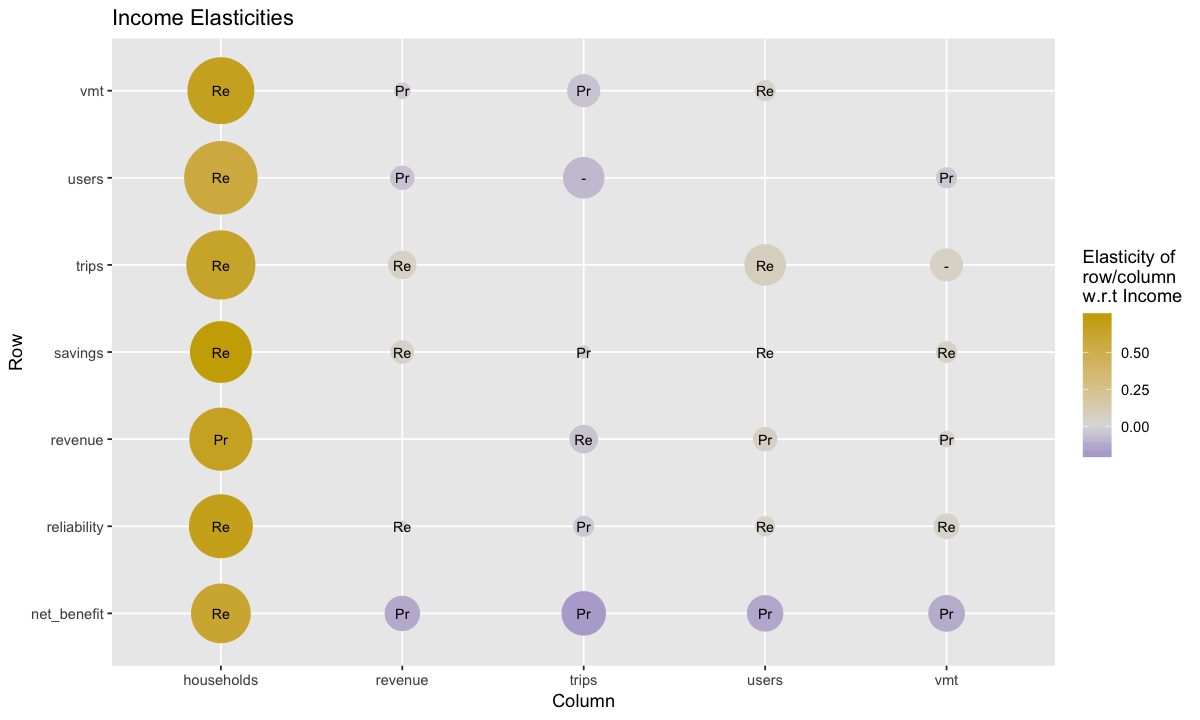

In [723]:
ggplot(income_equity, aes(unit, response)) + 
    geom_point(aes(color=est_slope, size=abs(t_slope))) + 
    geom_text(aes(label=progressive), size=3) +
    scale_size_continuous(range=c(1,20), guide=F) +
    scale_color_gradient2(low="#0022aa", mid="#dddddd", high="#ccaa00") + 
    labs(title="Income Elasticities", color="Elasticity of\nrow/column\nw.r.t Income", x="Column", y="Row")

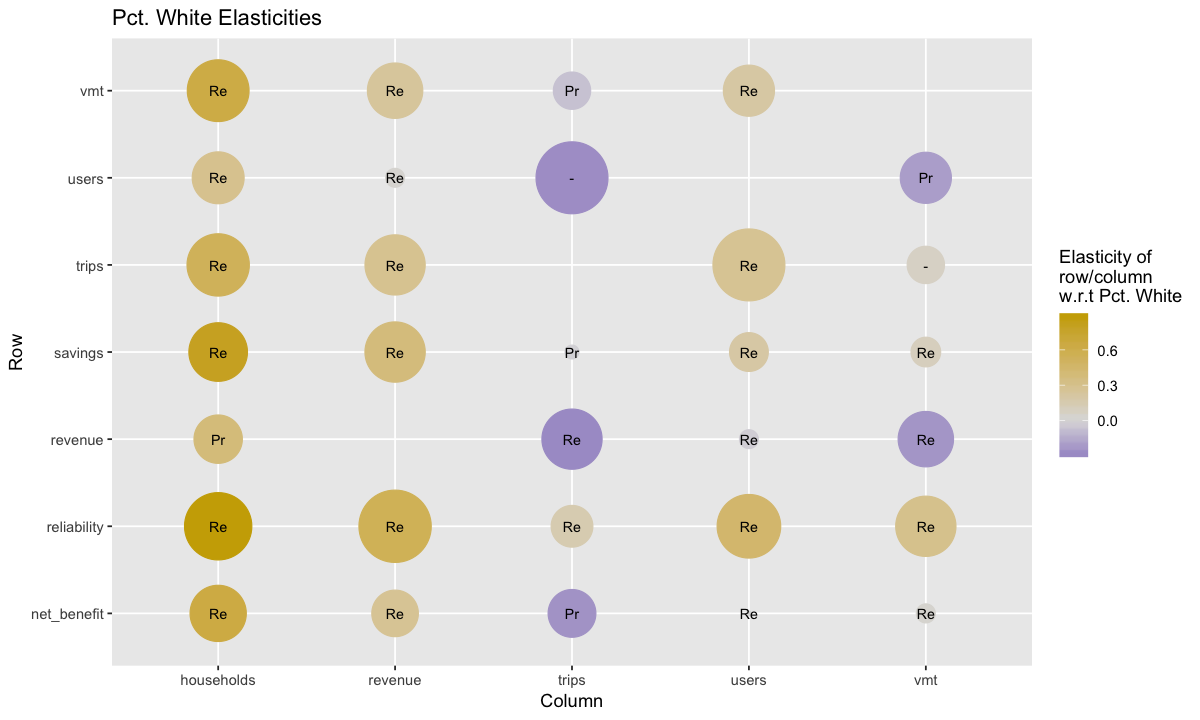

In [19]:
ggplot(race_equity, aes(unit, response)) + 
    geom_point(aes(color=est_slope, size=abs(t_slope))) + 
    geom_text(aes(label=progressive), size=3) +
    scale_size_continuous(range=c(1,20), guide=F) +
    scale_color_gradient2(low="#0022aa", mid="#dddddd", high="#ccaa00") + 
    labs(title="Pct. White Elasticities", color="Elasticity of\nrow/column\nw.r.t Pct. White", x="Column", y="Row")

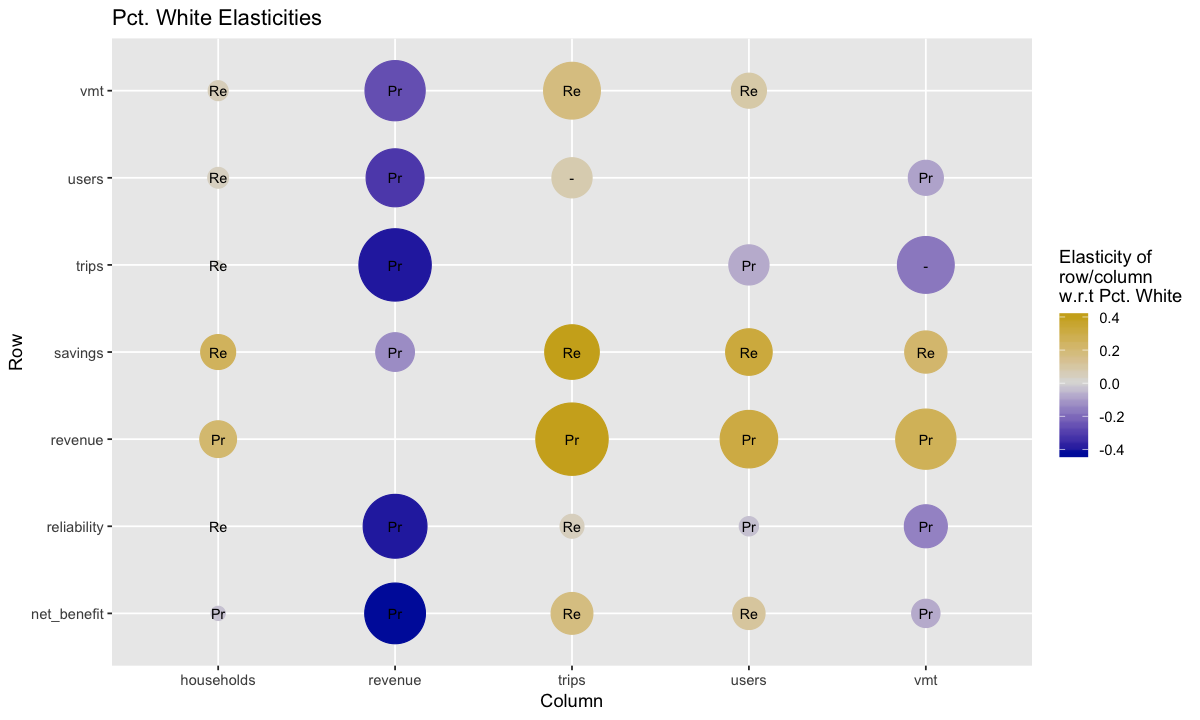

In [464]:
ggplot(race_equity, aes(unit, response)) + 
    geom_point(aes(color=est_slope, size=abs(t_slope))) + 
    geom_text(aes(label=progressive), size=3) +
    scale_size_continuous(range=c(1,20), guide=F) +
    scale_color_gradient2(low="#0022aa", mid="#dddddd", high="#ccaa00") + 
    labs(title="Pct. White Elasticities", color="Elasticity of\nrow/column\nw.r.t Pct. White", x="Column", y="Row")

In [724]:
income_equity_hov = crossing(
    response = c("trips", "users", "vmt", "savings", "reliability", "net_benefit"),
    unit = c("trips", "users", "households", "vmt")
) %>%
filter(response != unit) %>%
group_by(response, unit) %>%
group_modify(~ est_relation(fips_benefits, .y$response, .y$unit, "income", HOV=1)) %>%
mutate(progressive = case_when(
    response == "trips" & unit == "vmt" ~ "-",
    response == "users" & unit == "trips" ~ "-",
    response != "revenue" & est_slope > 0 ~ "Re",
    response != "revenue" & est_slope < 0 ~ "Pr",
    response == "revenue" & est_slope > 0 ~ "Pr",
    response == "revenue" & est_slope < 0 ~ "Re",
    T ~ "-"
))

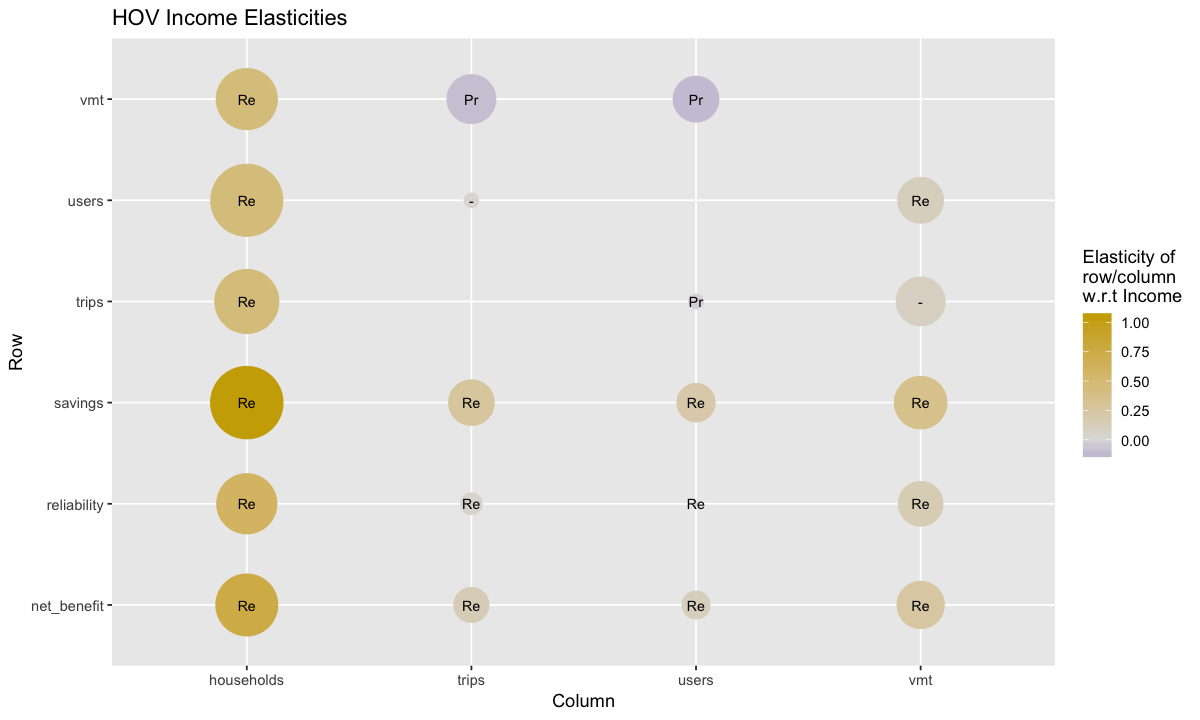

In [728]:
ggplot(income_equity_hov, aes(unit, response)) + 
    geom_point(aes(color=est_slope, size=abs(t_slope))) + 
    geom_text(aes(label=progressive), size=3) +
    scale_size_continuous(range=c(1,20), guide=F) +
    scale_color_gradient2(low="#0022aa", mid="#dddddd", high="#ccaa00") + 
    labs(title="HOV Income Elasticities", color="Elasticity of\nrow/column\nw.r.t Income", x="Column", y="Row")

In [726]:
race_equity_hov = crossing(
    response = c("trips", "users", "vmt", "savings", "reliability", "net_benefit"),
    unit = c("trips", "users", "households", "vmt")
) %>%
filter(response != unit) %>%
group_by(response, unit) %>%
group_modify(~ est_relation(fips_benefits, .y$response, .y$unit, "race", HOV=1)) %>%
mutate(progressive = case_when(
    response == "trips" & unit == "vmt" ~ "-",
    response == "users" & unit == "trips" ~ "-",
    response != "revenue" & est_slope > 0 ~ "Re",
    response != "revenue" & est_slope < 0 ~ "Pr",
    response == "revenue" & est_slope > 0 ~ "Pr",
    response == "revenue" & est_slope < 0 ~ "Re",
    T ~ "-"
))

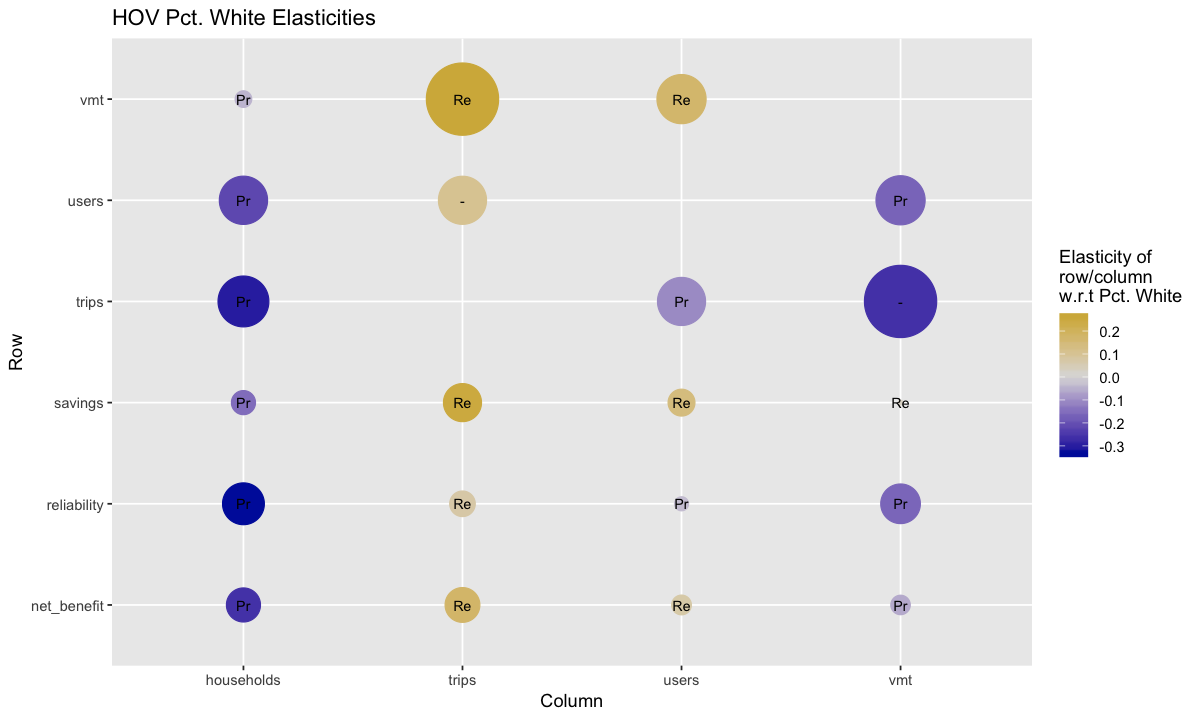

In [729]:
ggplot(race_equity_hov, aes(unit, response)) + 
    geom_point(aes(color=est_slope, size=abs(t_slope))) + 
    geom_text(aes(label=progressive), size=3) +
    scale_size_continuous(range=c(1,20), guide=F) +
    scale_color_gradient2(low="#0022aa", mid="#dddddd", high="#ccaa00") + 
    labs(title="HOV Pct. White Elasticities", color="Elasticity of\nrow/column\nw.r.t Pct. White", x="Column", y="Row")

## *Aside: low-frequency user analysis*

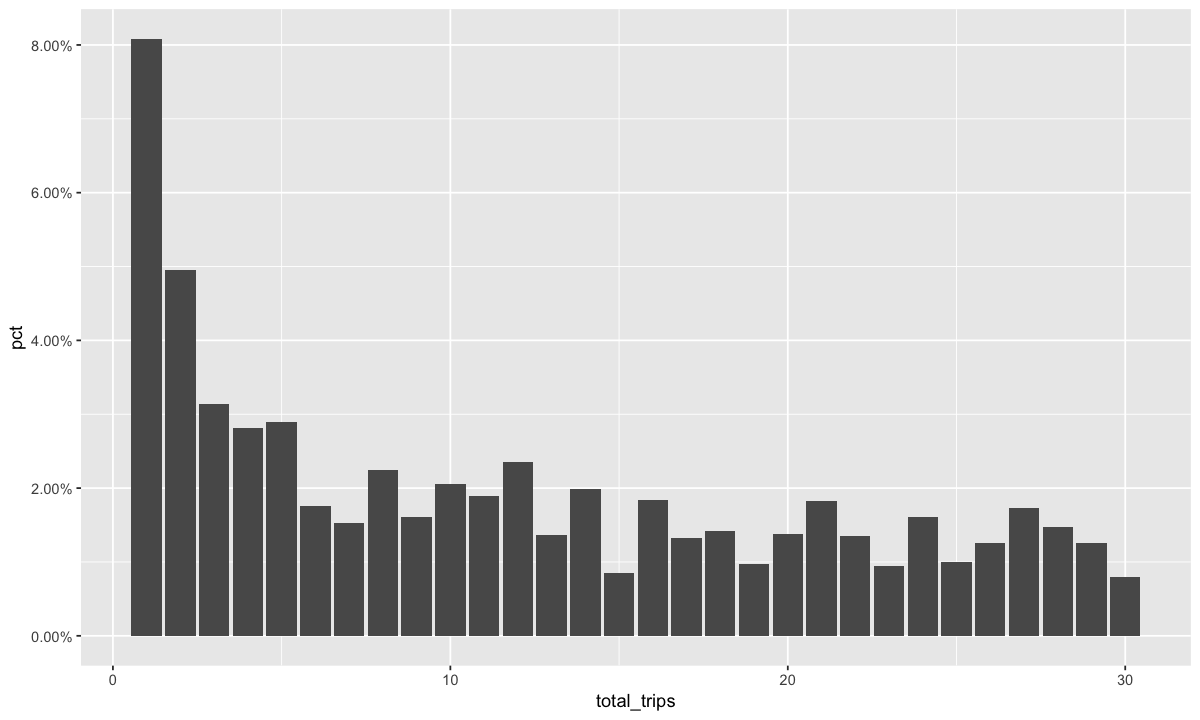

In [285]:
trips.2pct %>% 
    filter(total_trips <= 30) %>%
    #mutate(dist = exit_plaza-entry_plaza) %>%
    #group_by(total_trips, dist) %>%
    group_by(total_trips) %>%
    summarize(pct=mean(plate_state != "WA", na.rm=T)) %>%
ggplot(aes(total_trips, pct)) +
    #facet_wrap("total_trips", nrow=1) +
    geom_col() +
    scale_y_continuous(labels=scales::percent)

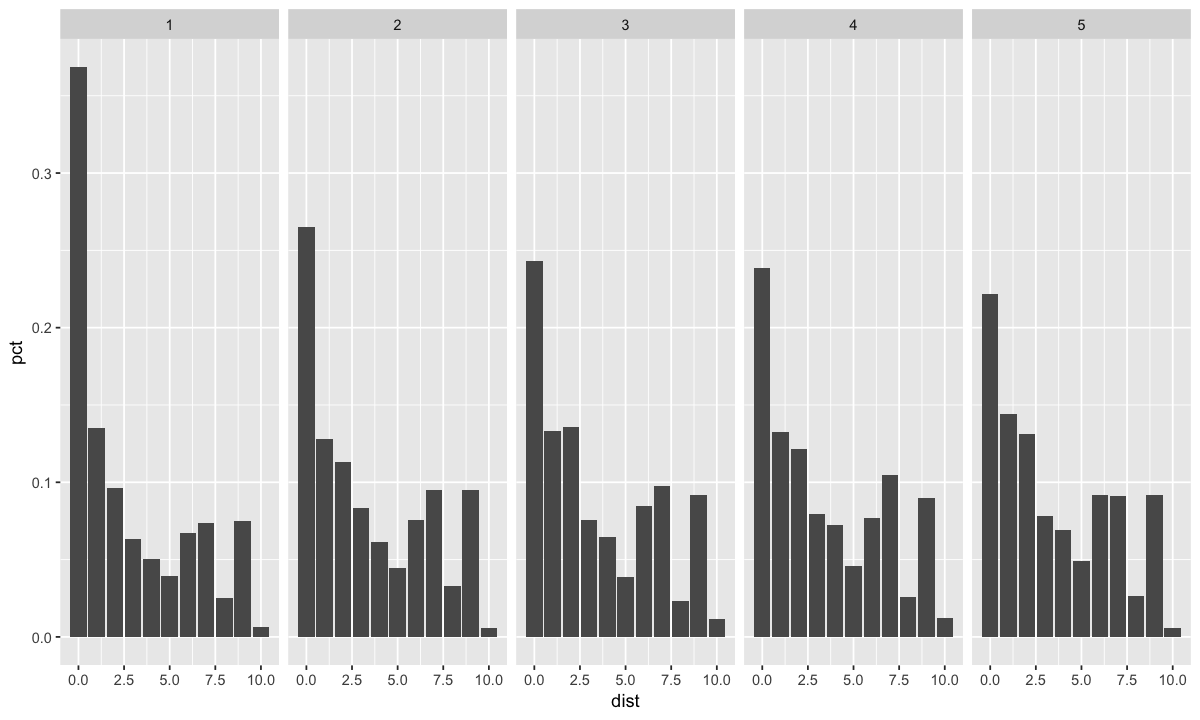

In [212]:
trips.2pct %>% 
    filter(total_trips <= 5) %>%
    mutate(dist = exit_plaza-entry_plaza) %>%
    group_by(total_trips) %>%
    mutate(total=n()) %>%
    group_by(total_trips, dist) %>%
    summarize(pct=n()/mean(total)) %>%
ggplot(aes(dist, pct)) +
    facet_wrap("total_trips", nrow=1) +
    geom_col()

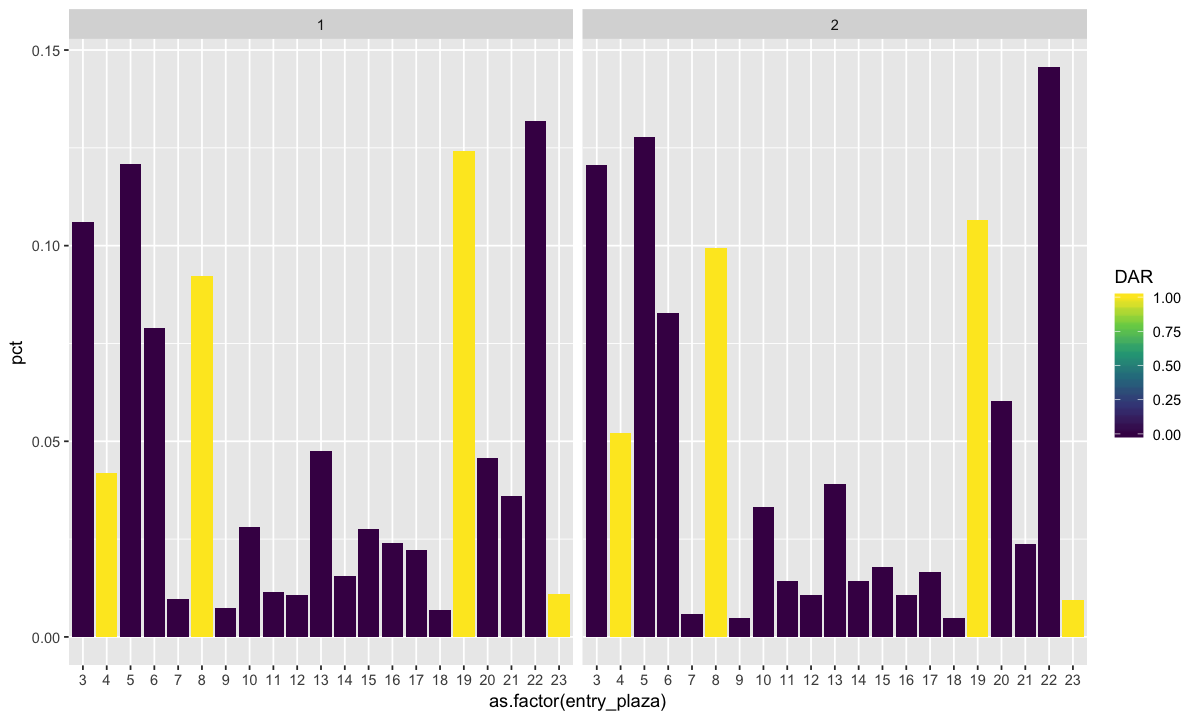

In [219]:
trips.2pct %>% 
    filter(total_trips <= 2, entry_plaza==exit_plaza) %>%
    group_by(total_trips) %>%
    mutate(total=n(), DAR=(entry_plaza %in% c(4, 8, 19, 23))) %>%
    group_by(total_trips, entry_plaza) %>%
    summarize(pct=n()/mean(total), DAR=mean(DAR)) %>%
ggplot(aes(as.factor(entry_plaza), pct, fill=DAR)) +
    facet_wrap("total_trips", nrow=1) +
    geom_col()

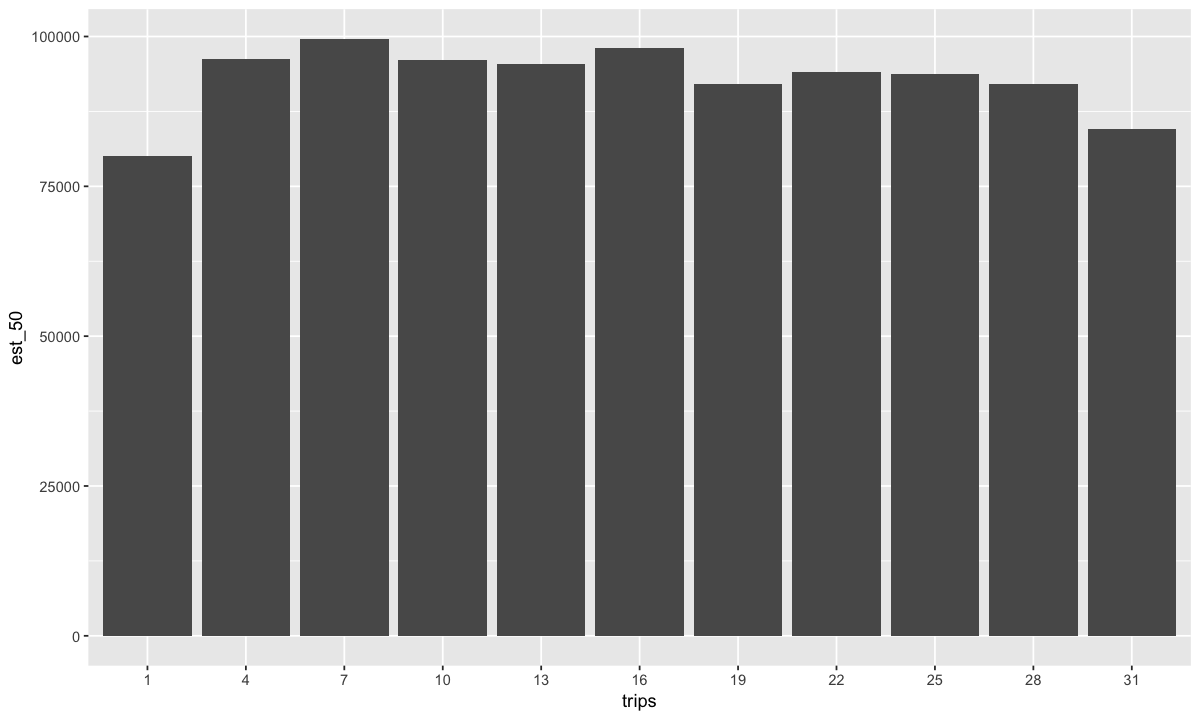

In [254]:
all_counts = acs %>% 
    mutate(group="All") %>%
    inc_distr_by(group, weight=population) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

fit_all = fit_dagum(all_counts$count, acs_bins)

trips.2pct %>% 
    filter(total_trips <= 30) %>%
    mutate(trips = as_factor(ceiling((total_trips+2)/3)*3-2)) %>%
    block_counts_by(trips, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(0.5, fit_all, N=50000) %>%
ggplot(aes(trips, est_50), group=1) + geom_col()

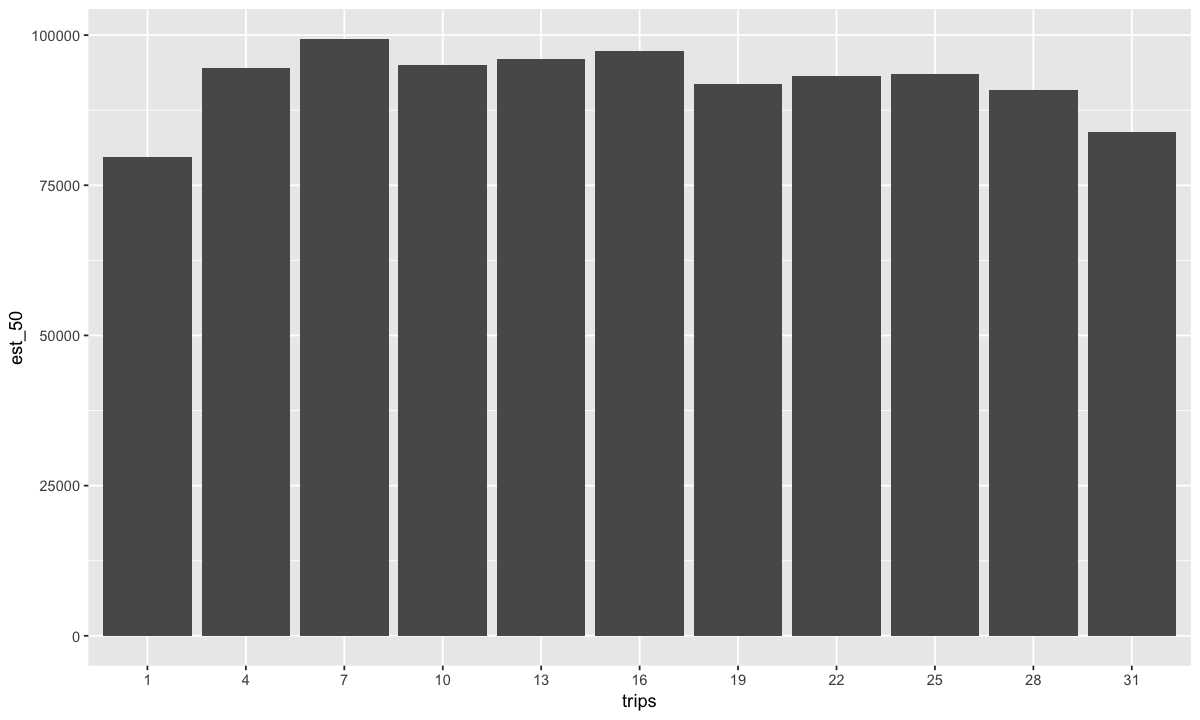

In [288]:
trips.2pct %>% 
    filter(total_trips <= 30) %>%
    mutate(trips = as_factor(ceiling((total_trips+2)/3)*3-2)) %>%
    block_counts_by(trips, acs) %>%
    filter(str_sub(fips, 4, 5) %in% c("33", "61")) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(0.5, fit_all, N=50000) %>%
ggplot(aes(trips, est_50), group=1) + geom_col()

# Frequency distribution

In [190]:
freq_benefits = trips.2pct %>%
    filter(commercial==0) %>%
    select(toll, entry_time, entry=entry_plaza, exit=exit_plaza, is_hov, id, freq, savings) %>%
    mutate(date_time_1 = as_datetime(as.integer(entry_time/60)*60),
           date_time_5 = as_datetime(as.integer(entry_time/300)*300),
           tod = 100*hour(date_time_5) + minute(date_time_5),
           hour = hour(as_datetime(entry_time)),
           peak = (hour >= 5 & hour < 9) | (hour >= 15 & hour < 19),
           occup_wgt = ifelse(is_hov, ifelse(peak, 3, 2), 1),
           freq_num = parse_number(freq)) %>%
    left_join(reliability, by=c("tod", "entry", "exit")) %>%
    left_join(trip_length_lookup, by=c("entry", "exit")) %>%
    select(freq, freq_num, is_hov, occup_wgt, id, toll, peak, trip_length, savings, reliability) %>%
    group_by(freq, freq_num, is_hov) %>%
    summarize(trips = n(),
              users = n_distinct(id),
              revenue = sum(toll, na.rm=T),
              vmt = sum(trip_length, na.rm=T),
              savings = sum(savings*occup_wgt, na.rm=T),
              peak_trips = sum(peak, na.rm=T),
              reliability = sum(reliability*occup_wgt, na.rm=T)) %>%
    arrange(freq, is_hov) %>%
    mutate(savings_benefit = VOT*savings,
           reliability_benefit = VOR*reliability,
           total_benefit = VOT*savings + VOR*reliability,
           net_benefit = total_benefit - revenue)

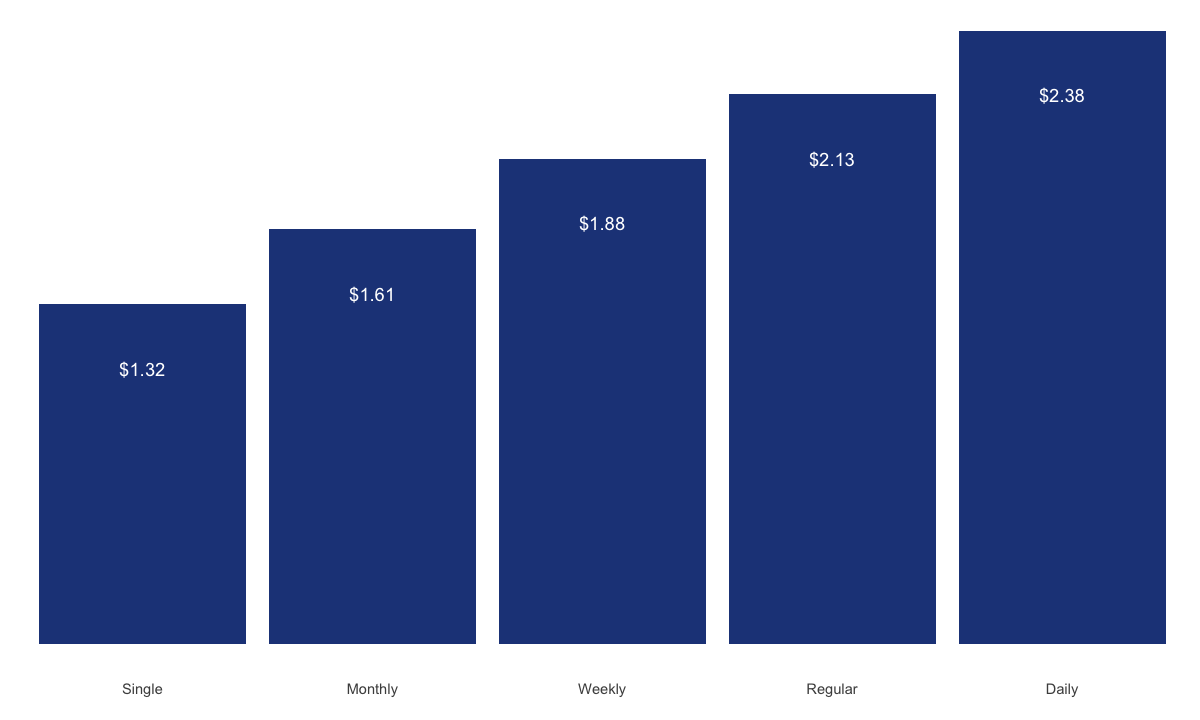

In [196]:
freq_benefits %>%
    filter(is_hov==0, !is.na(freq), freq != "6_high") %>%
ggplot(aes(freq, net_benefit/trips)) +
    geom_col(fill="#224488") + 
    geom_text(aes(label=scales::dollar(net_benefit/trips)), nudge_y=-0.25, color="white") +
    scale_x_discrete(labels=function(x) str_to_title(str_sub(x, 3))) +
    labs(x="") + guides(fill=F) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank(),
          plot.margin = grid::unit(c(0,0,0,0), "mm"))
                     
ggsave("../../../img/freq_benefits.png", width=3.25, height=3, dpi=320)

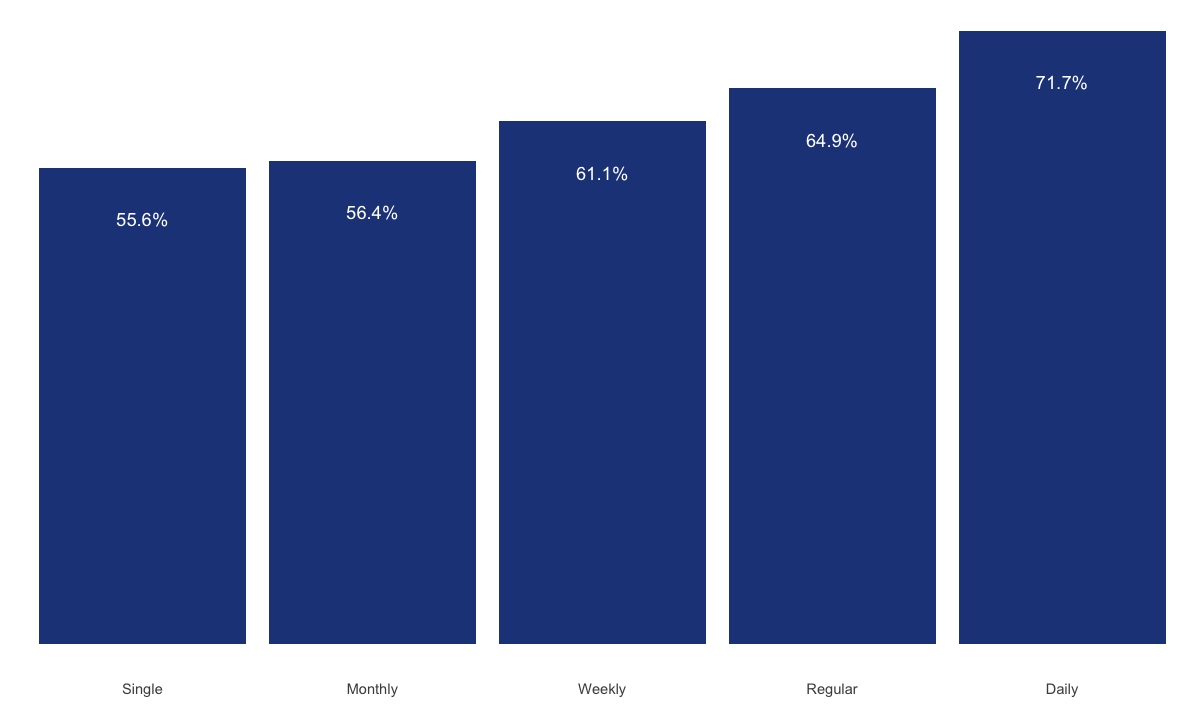

In [197]:
freq_benefits %>%
    filter(is_hov==0, !is.na(freq), freq != "6_high") %>%
ggplot(aes(freq, peak_trips/trips)) +
    geom_col(fill="#224488") + 
    geom_text(aes(label=scales::percent(peak_trips/trips)), nudge_y=-0.06, color="white") +
    scale_x_discrete(labels=function(x) str_to_title(str_sub(x, 3))) +
    labs(x="") + guides(fill=F) +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank(),
          plot.margin = grid::unit(c(0,0,0,0), "mm"))
                     
ggsave("../../../img/freq_peak.png", width=3.25, height=3, dpi=320)

In [843]:
freq_relation = function(response, unit, HOV=0) {
    if (rlang::quo_is_symbol(enquo(response))) 
        response = enquo(response)
    else 
        response = sym(as.character(response))
    
    if (rlang::quo_is_symbol(enquo(unit))) 
        unit = enquo(unit)
    else 
        unit = sym(as.character(unit))
    
    freq_benefits %>%
        filter(is_hov == 0, freq_num < 6) %>%
        transmute(y = !!response / !!unit)
}

In [856]:
freq_equity = crossing(
    response = c("vmt", "revenue", "savings", "reliability", "net_benefit"),
    unit = c("trips", "revenue", "vmt")
) %>%
filter(response != unit) %>%
group_by(response, unit) %>%
group_modify(~ freq_relation(.y$response, .y$unit))

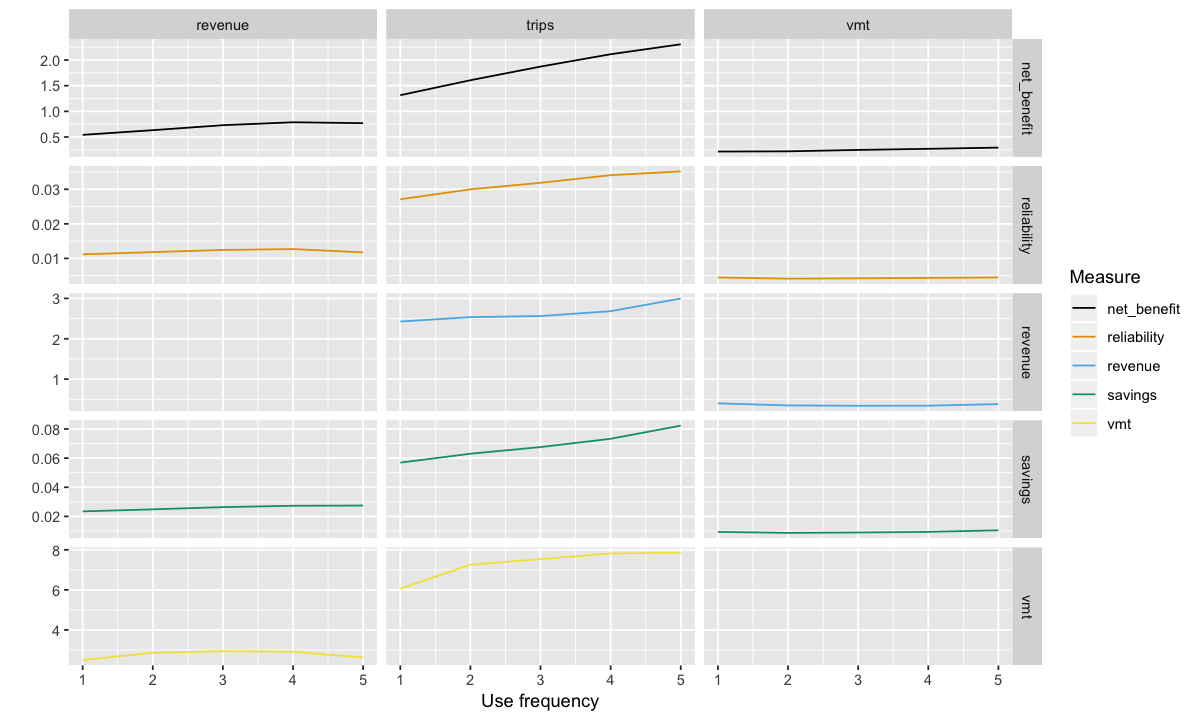

In [858]:
cb.palette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

freq_equity %>%
    #filter(!(response %in% c("savings", "reliability"))) %>%
    #filter(!(unit %in% c("vmt"))) %>%
ggplot(aes(freq_num, y, color=response, group=response)) +
    facet_grid(response ~ unit, scales="free") +
    #facet_wrap("unit", scales="free") +
    geom_line() +
    scale_color_manual(values=cb.palette) + 
    #scale_y_continuous(labels=scales::dollar) +
    labs(x="Use frequency", y="", color="Measure")

# Time of day analysis

In [291]:
grouping = sym("group")
time_benefits = trips.2pct %>%
    select(toll, entry_time, entry=entry_plaza, exit=exit_plaza, is_hov, id, freq, savings) %>%
    mutate(date_time_1 = as_datetime(as.integer(entry_time/60)*60),
           date_time_5 = as_datetime(as.integer(entry_time/300)*300),
           tod = 100*hour(date_time_5) + minute(date_time_5),
           hour = hour(as_datetime(entry_time)),
           wday = wday(date_time_1, label=T),
           month = month(date_time_1, label=T),
           direction = ifelse(entry <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = case_when(am_peak & direction=="SB" ~ "AM peak SB",
                             pm_peak & direction=="NB" ~ "PM peak NB",
                             am_peak & direction=="NB" ~ "Reverse\ncommute",
                             pm_peak & direction=="SB" ~ "Reverse\ncommute",
                             T ~ "Off-peak"),
           occup_wgt = ifelse(is_hov, ifelse(peak, 3, 2), 1)) %>%
    left_join(reliability, by=c("tod", "entry", "exit")) %>%
    left_join(trip_length_lookup, by=c("entry", "exit")) %>%
    select(!!grouping, is_hov, occup_wgt, id, toll, trip_length, savings, reliability) %>%
    group_by(!!grouping, is_hov) %>%
    summarize(trips = n(),
              users = n_distinct(id),
              revenue = sum(toll, na.rm=T),
              vmt = sum(trip_length, na.rm=T),
              savings = sum(savings*occup_wgt, na.rm=T),
              reliability = sum(reliability*occup_wgt, na.rm=T)) %>%
    arrange(!!grouping, is_hov) %>%
    mutate(savings_benefit = VOT*savings,
           reliability_benefit = VOR*reliability,
           total_benefit = VOT*savings + VOR*reliability,
           net_benefit = total_benefit - revenue)

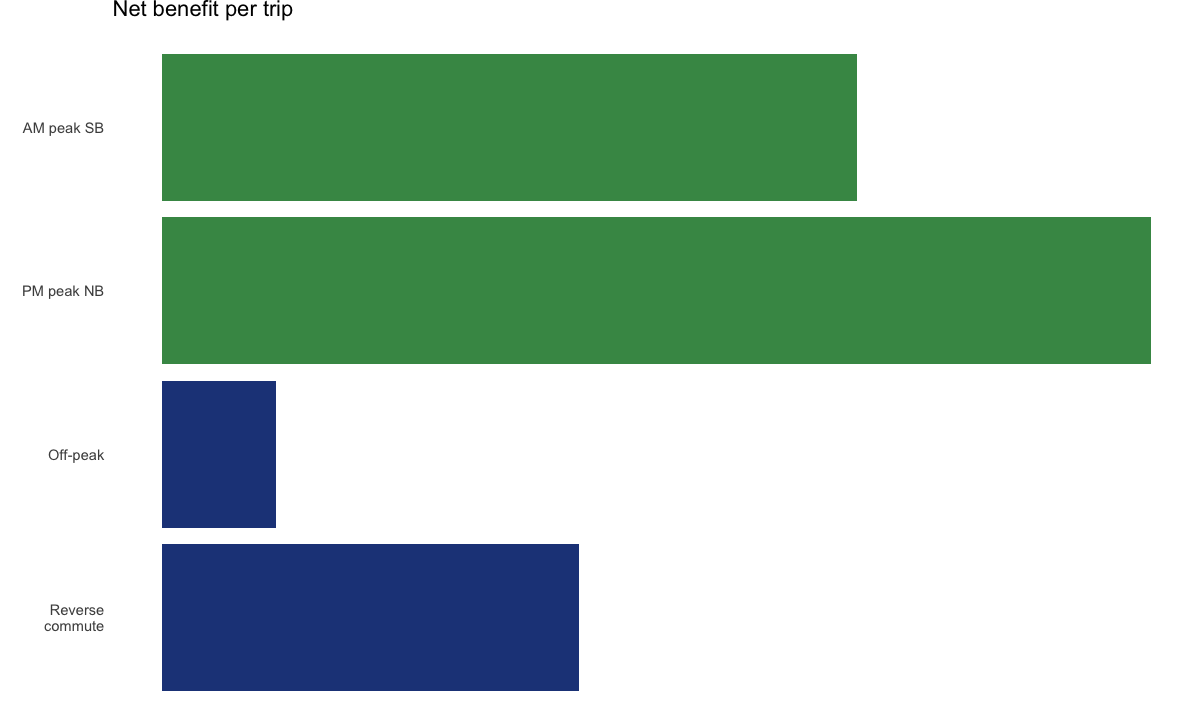

In [304]:
time_benefits %>%
    filter(is_hov==0) %>%
    mutate(peak = group %in% c("AM peak SB", "PM peak NB"),) %>%
ggplot(aes(fct_rev(fct_relevel(as.factor(!!grouping), "AM peak SB", "PM peak NB")), net_benefit/trips, group=1)) + 
    geom_col(aes(fill=peak)) + #"#224488") +  
    scale_fill_manual(values=c("#224488", "#449555")) +
    #geom_text(aes(label=scales::dollar(net_benefit/trips)), color="#444444", nudge_y=+0.3) +
    labs(x="") + guides(fill=F) +
    ggtitle("Net benefit per trip") +
    #ylim(0, 3.6) +
    theme_minimal() +
    coord_flip() +
    theme(panel.grid = element_blank(),
          axis.text.x = element_blank(),
          axis.title.x = element_blank(),
          plot.margin = grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/benefit_peak.png", height=3, width=3.25, dpi=320)
#ggsave("../../../img/benefit_peak.png", height=3, width=6.5, dpi=320)
    #geom_col() +
    #geom_hline(yintercept=0, lty="dashed") + 
    #scale_y_continuous(labels=scales::dollar)

In [238]:
grouping = sym("hour")
time_benefits = trips.2pct %>%
    select(toll, entry_time, entry=entry_plaza, exit=exit_plaza, is_hov, id, freq, savings) %>%
    mutate(date_time_1 = as_datetime(as.integer(entry_time/60)*60),
           date_time_5 = as_datetime(as.integer(entry_time/300)*300),
           tod = 100*hour(date_time_5) + minute(date_time_5),
           hour = hour(as_datetime(entry_time)),
           wday = wday(date_time_1, label=T),
           month = month(date_time_1, label=T),
           direction = ifelse(entry <= 12, "NB", "SB"),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           group = case_when(am_peak & direction=="SB" ~ "AM peak",
                             pm_peak & direction=="NB" ~ "PM peak",
                             T ~ "Off-peak"),
           occup_wgt = ifelse(is_hov, ifelse(peak, 3, 2), 1)) %>%
    left_join(reliability, by=c("tod", "entry", "exit")) %>%
    left_join(trip_length_lookup, by=c("entry", "exit")) %>%
    select(!!grouping, is_hov, occup_wgt, id, toll, trip_length, savings, reliability) %>%
    group_by(!!grouping, is_hov) %>%
    summarize(trips = n(),
              users = n_distinct(id),
              revenue = sum(toll, na.rm=T),
              vmt = sum(trip_length, na.rm=T),
              savings = sum(savings*occup_wgt, na.rm=T),
              reliability = sum(reliability*occup_wgt, na.rm=T)) %>%
    arrange(!!grouping, is_hov) %>%
    mutate(savings_benefit = VOT*savings,
           reliability_benefit = VOR*reliability,
           total_benefit = VOT*savings + VOR*reliability,
           net_benefit = total_benefit - revenue)

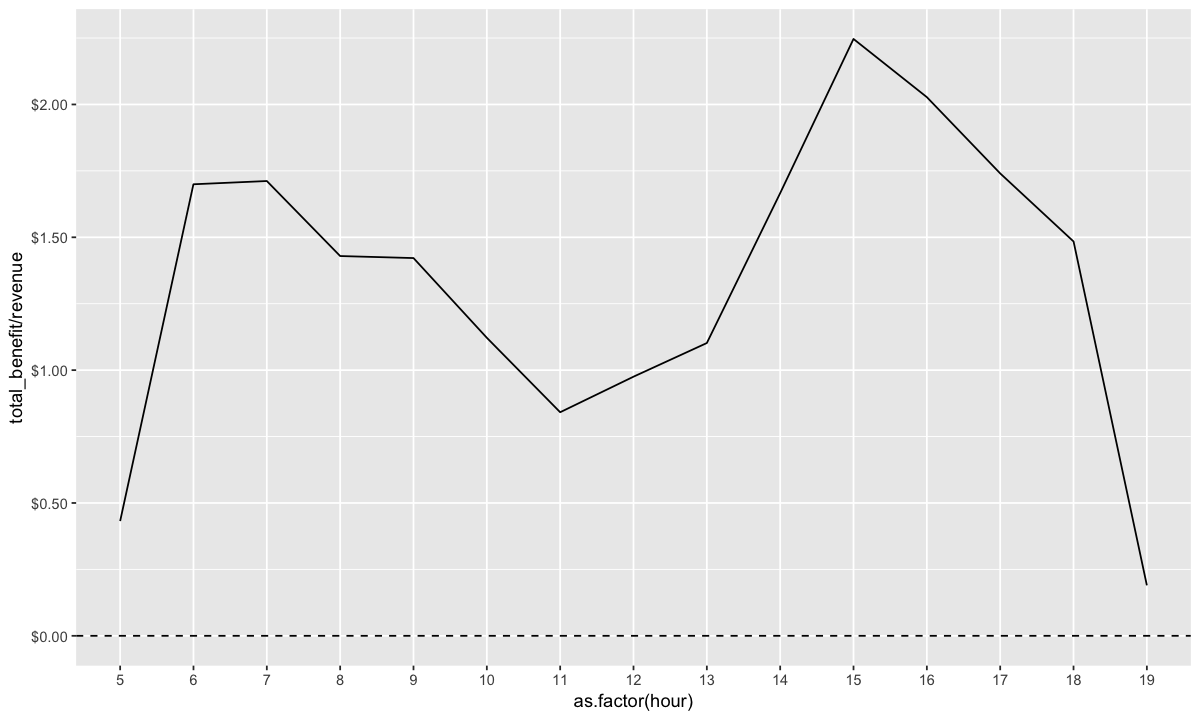

In [239]:
time_benefits %>%
    filter(is_hov==0) %>%
ggplot(aes(as.factor(!!grouping), total_benefit/revenue, group=1)) + 
    geom_line() +
    geom_hline(yintercept=0, lty="dashed") + 
    scale_y_continuous(labels=scales::dollar)

In [755]:
head(income_equity)

response,unit,est_intercept,est_slope,se_intercept,se_slope,t_slope,vary_slopes,progressive
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
net_benefit,households,-1.6973165,0.6115427,0.2029331,0.08397899,7.282091,FALSE,Re
net_benefit,revenue,-0.4556138,-0.1308857,0.1234603,0.05271690,-2.482804,TRUE,Pr
net_benefit,trips,0.1130535,-0.1850925,0.1123641,0.04692978,-3.944031,TRUE,Pr
net_benefit,users,0.6875979,-0.1396447,0.1266226,0.05301829,-2.633897,TRUE,Pr
net_benefit,vmt,-1.7766043,-0.1266490,0.1125651,0.04766486,-2.657073,TRUE,Pr
reliability,households,-5.7431938,0.6929011,0.2040534,0.08249510,8.399301,TRUE,Re


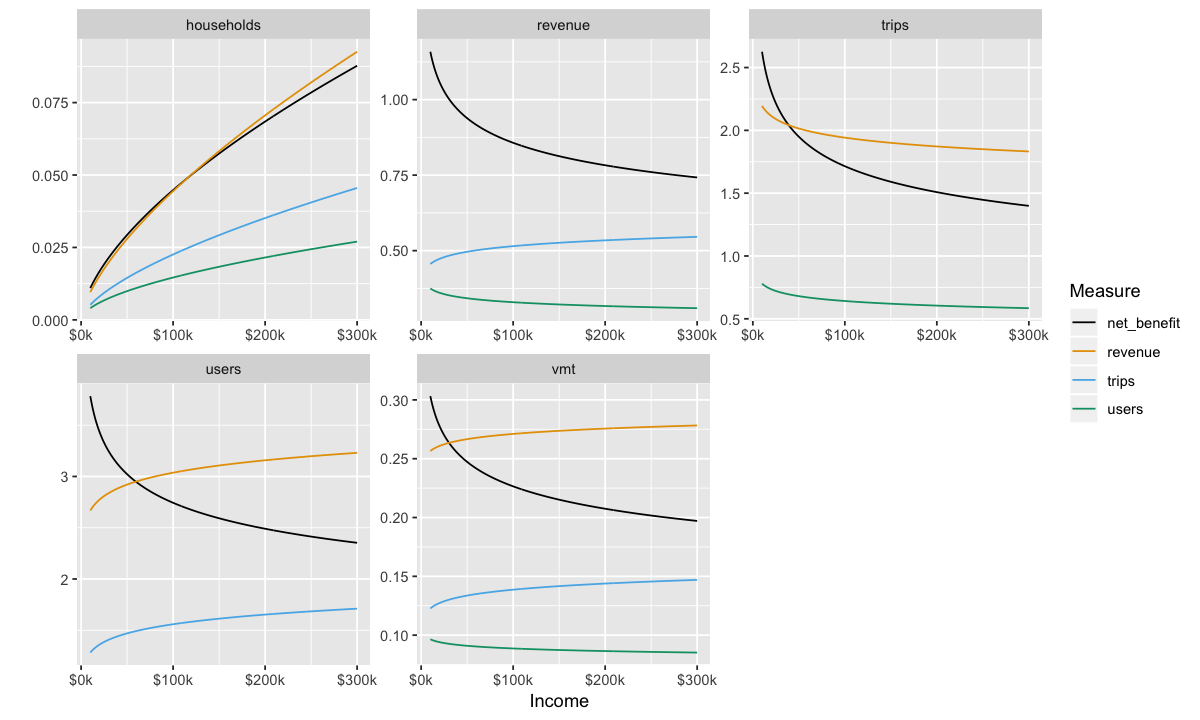

In [801]:
x = seq(10, 300)
cb.palette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")


income_equity %>%
    filter(!(response %in% c("vmt", "savings", "reliability"))) %>%
    group_by(response, unit) %>%
    group_modify(~ tibble(income=x, value=exp(.$est_intercept + .$est_slope*log(x/1e3)))) %>%
ggplot(aes(income, value, color=response, group=response)) +
    #facet_grid(response ~ unit, scales="free") +
    facet_wrap("unit", scales="free") +
    geom_line() +
    scale_color_manual(values=cb.palette) + 
    #scale_y_continuous(labels=scales::dollar) +
    scale_x_continuous(labels=function(x) paste0(scales::dollar(x), "k")) + 
    labs(x="Income", y="", color="Measure")

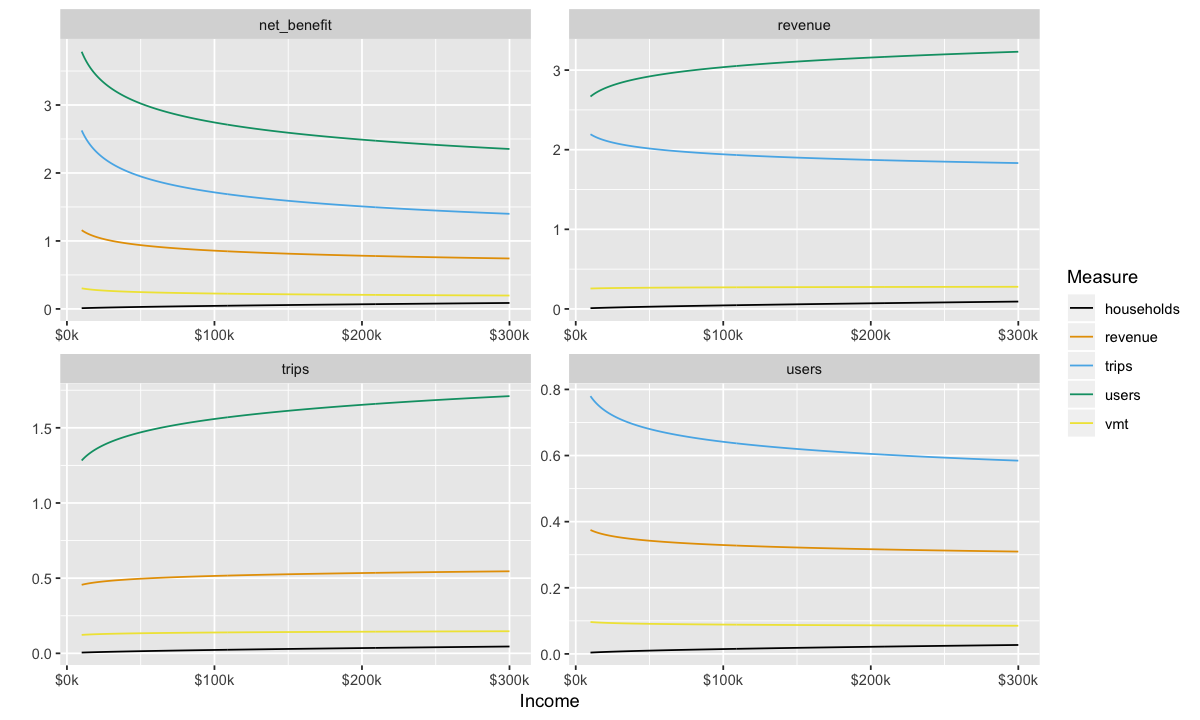

In [25]:
x = seq(10, 300)
cb.palette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")


income_equity %>%
    filter(!(response %in% c("vmt", "savings", "reliability"))) %>%
    group_by(response, unit) %>%
    group_modify(~ tibble(income=x, value=exp(.$est_intercept + .$est_slope*log(x/1e3)))) %>%
ggplot(aes(income, value, color=unit, group=unit)) +
    #facet_grid(response ~ unit, scales="free") +
    facet_wrap("response", scales="free") +
    geom_line() +
    scale_color_manual(values=cb.palette) + 
    #scale_y_continuous(labels=scales::dollar) +
    scale_x_continuous(labels=function(x) paste0(scales::dollar(x), "k")) + 
    labs(x="Income", y="", color="Measure")

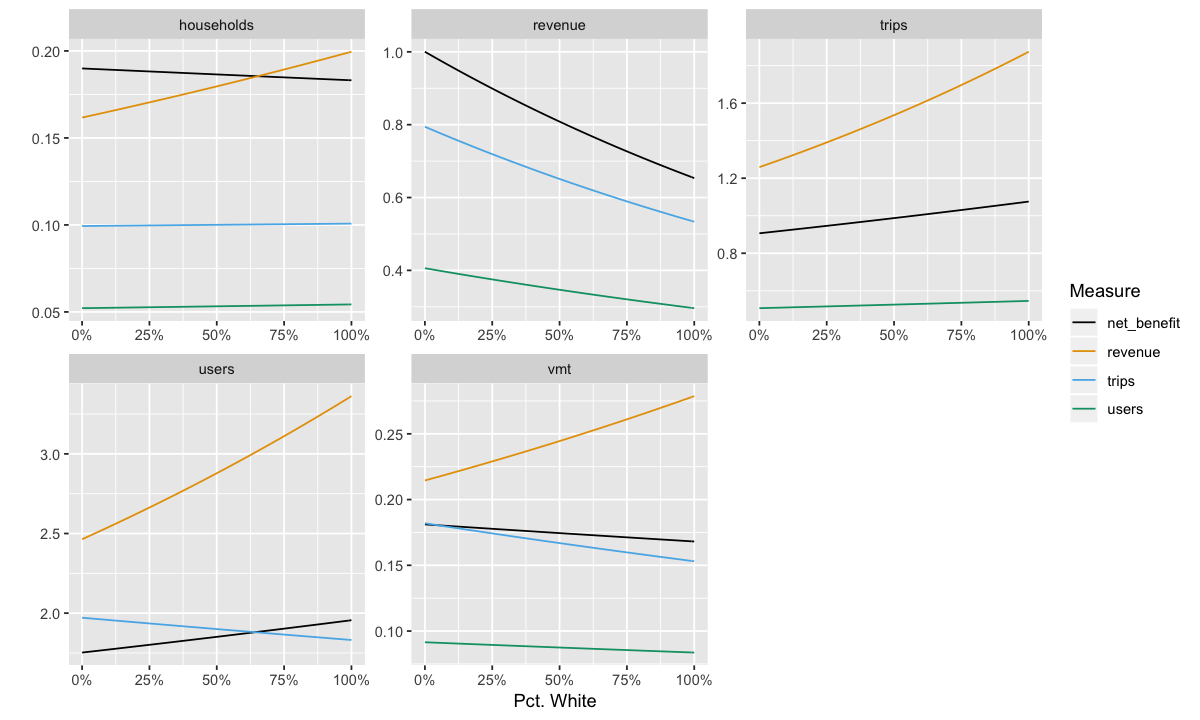

In [804]:
x = seq(0, 1, 0.01)
cb.palette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

race_equity %>%
    filter(!(response %in% c("vmt", "savings", "reliability"))) %>%
    group_by(response, unit) %>%
    group_modify(~ tibble(pct_white=x, value=exp(.$est_intercept + .$est_slope*x))) %>%
ggplot(aes(pct_white, value, color=response, group=response)) +
    #facet_grid(response ~ unit, scales="free") +
    facet_wrap("unit", scales="free") +
    geom_line() +
    scale_color_manual(values=cb.palette) + 
    #scale_y_continuous(labels=scales::dollar) +
    scale_x_continuous(labels=scales::percent) +
    labs(x="Pct. White", y="", color="Measure")

In [93]:
head(trips.2pct)

trip_id,def_id,toll,entry_time,exit_time,entry_plaza,exit_plaza,is_hov,tag_id,id,⋯,freq,commercial,savings,reliability,households,population,mean_inc,med_inc,race_nonhisp_asian,race_nonhisp_white
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
104022661,2692,0.75,1514878872,1514878872,5,5,0,3883355025317432832,4718396806487642112,⋯,6_high,1,0.00000000,0.00000000,252,873,213355.0,128654,0.06185567,0.5876289
104023264,2686,0.75,1514875917,1514876323,4,7,0,8086582210306091008,-7228328777495153664,⋯,6_high,1,0.00000000,0.00000000,596,1463,161011.0,120938,0.15721121,0.7416268
104024189,2706,0.75,1514880965,1514881452,16,23,0,-2579695942875726336,6765682015448136704,⋯,4_regular,0,0.03577778,0.04163889,811,2031,112676.7,90840,0.34859675,0.5795175
104024193,2705,0.75,1514878538,1514878585,16,17,0,-1807528794687702784,-9189267815259293696,⋯,4_regular,0,0.01750000,0.02022222,498,1351,120629.7,92333,0.35751295,0.5122132
104024246,2711,0.00,1514878566,1514879056,14,17,1,NA,NA,⋯,NA,NA,0.20761111,0.00802500,NA,NA,NA,NA,NA,NA
104024595,2694,0.75,1514906339,1514906990,5,12,0,4768809296734673920,-79136306211544352,⋯,5_daily,0,0.02405556,0.05307778,970,1871,102428.6,91313,0.23516836,0.6664885


In [185]:
route_benefits = trips.2pct %>%
    filter(is_hov==0, commercial==0) %>%
    select(toll, entry_time, entry=entry_plaza, exit=exit_plaza, is_hov, id, freq, savings) %>%
    mutate(date_time_1 = as_datetime(as.integer(entry_time/60)*60),
           date_time_5 = as_datetime(as.integer(entry_time/300)*300),
           tod = 100*hour(date_time_5) + minute(date_time_5),
           hour = hour(as_datetime(entry_time)),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           peak_group = if_else(am_peak, "AM peak", if_else(pm_peak, "PM peak", "Off-peak"))) %>%
    left_join(reliability, by=c("tod", "entry", "exit")) %>%
    left_join(trip_length_lookup, by=c("entry", "exit")) %>%
    mutate(direction = if_else(entry <= 12, "Northbound", "Southbound"),
           entry = if_else(direction == "Northbound", entry-2, entry-12),
           exit = if_else(direction == "Northbound", exit-2, exit-12),
           trip_id = sprintf("%s_%02i_%02i", direction, entry, exit)) %>%
    select(entry, exit, direction, trip_id, id, peak_group, toll, trip_length, savings, reliability) %>%
    group_by(entry, exit, direction, peak_group, trip_id) %>%
    summarize(trips = n(),
              users = n_distinct(id),
              revenue = sum(toll, na.rm=T),
              vmt = sum(trip_length, na.rm=T),
              savings = sum(savings, na.rm=T),
              reliability = sum(reliability, na.rm=T)) %>%
    mutate(savings_benefit = VOT*savings,
           reliability_benefit = VOR*reliability,
           total_benefit = VOT*savings + VOR*reliability,
           net_benefit = total_benefit - revenue)

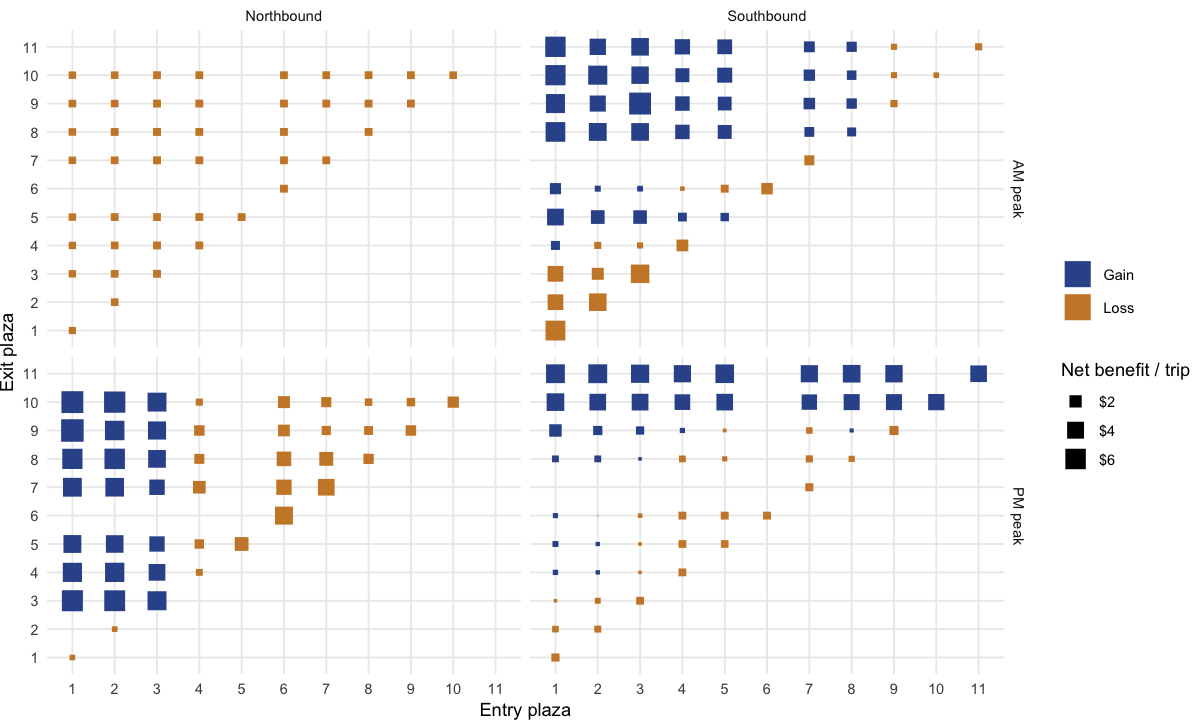

In [301]:
route_benefits %>%
    filter(peak_group != "Off-peak") %>%
ggplot(aes(as_factor(entry), as_factor(exit), 
           color=as_factor(-sign(net_benefit/trips)), 
           #size=trips)) +
           size=abs(net_benefit/trips))) +
    #facet_wrap("direction") +
    facet_grid(peak_group ~ direction) +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#335599", "#cc8833"), labels=c("Gain", "Loss")) +
    scale_size_continuous(labels=scales::dollar, range=c(0, 6)) +
    guides(color=guide_legend(override.aes=list(size=7))) +
    labs(size="Net benefit / trip", color="", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

#ggsave("../../../img/benefit_route.png", width=6.5, height=5, dpi=320)

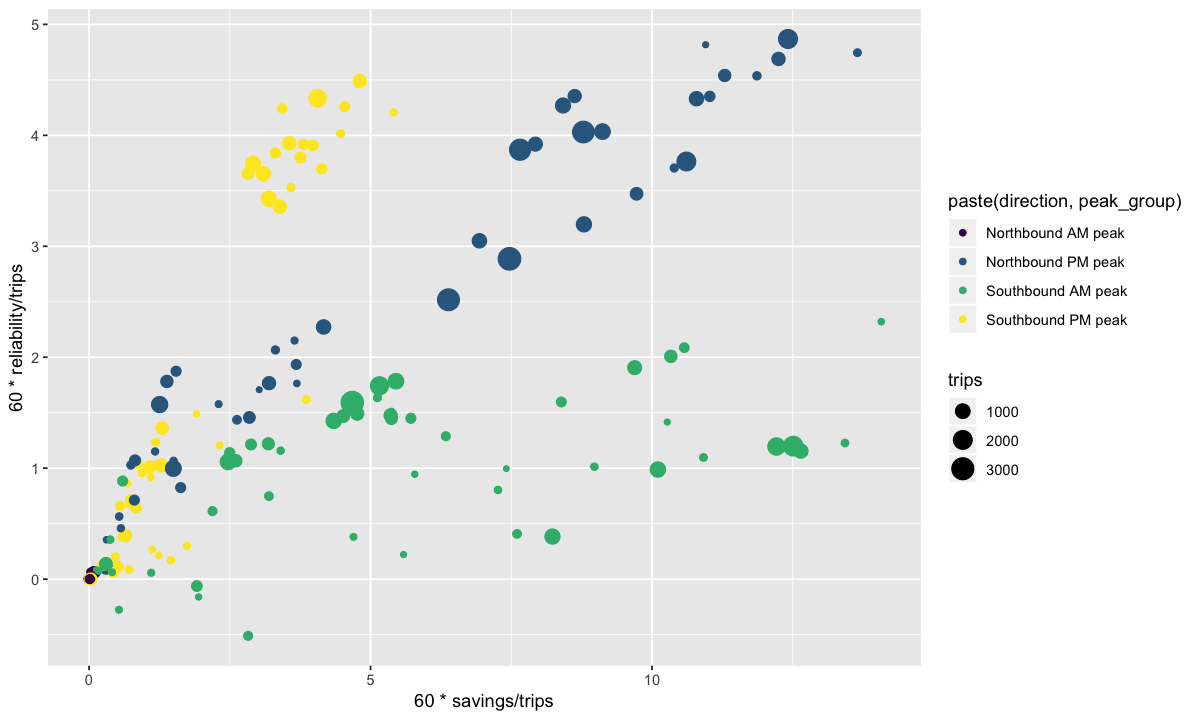

In [156]:
ggplot(route_benefits, aes(60*savings/trips, 60*reliability/trips, color=paste(direction, peak_group), size=trips)) + 
    geom_point() +
    scale_color_viridis_d()

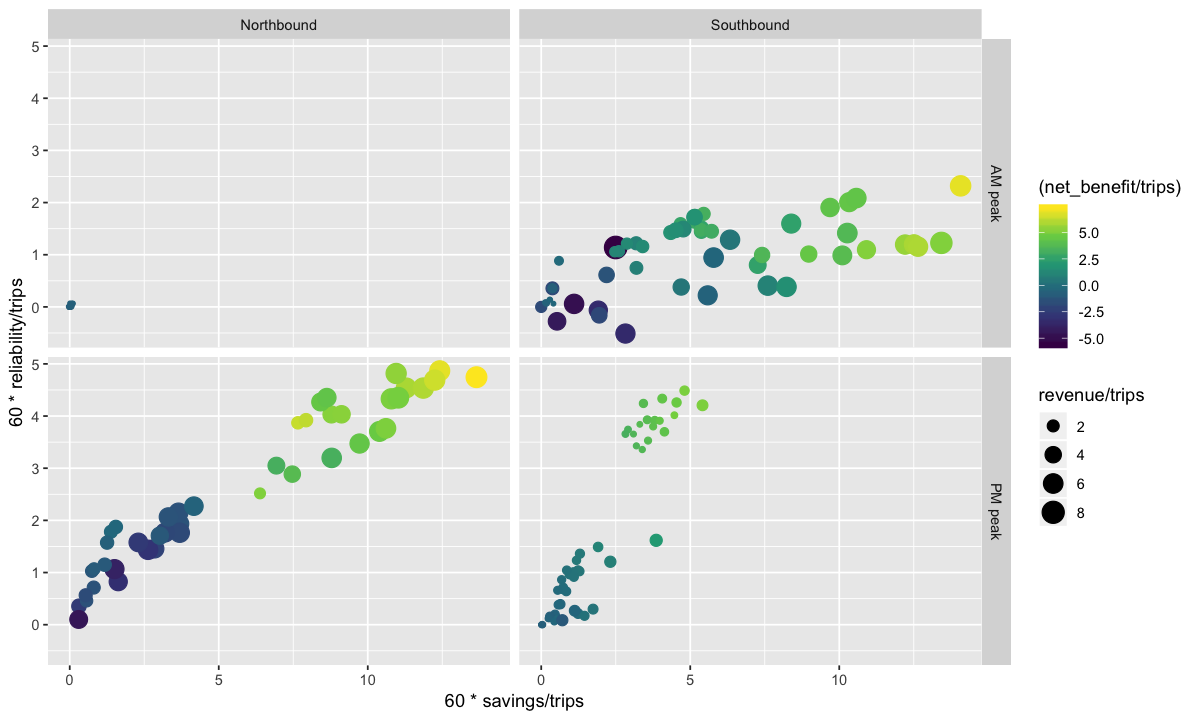

In [168]:
ggplot(route_benefits, aes(60*savings/trips, 60*reliability/trips, color=(net_benefit/trips), size=revenue/trips)) + 
    facet_grid(peak_group ~ direction) +
    geom_point() +
    scale_color_viridis_c()

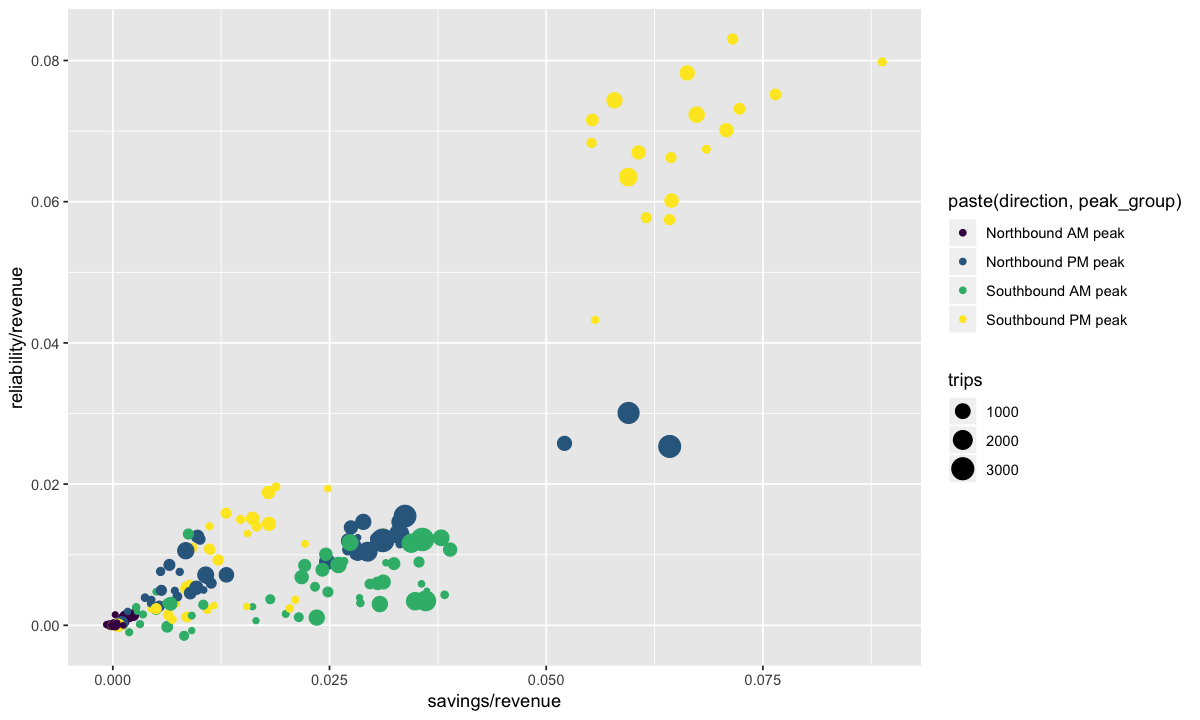

In [162]:
ggplot(route_benefits, aes(savings/revenue, reliability/revenue, color=paste(direction, peak_group), size=trips)) + 
    geom_point() +
    scale_color_viridis_d()

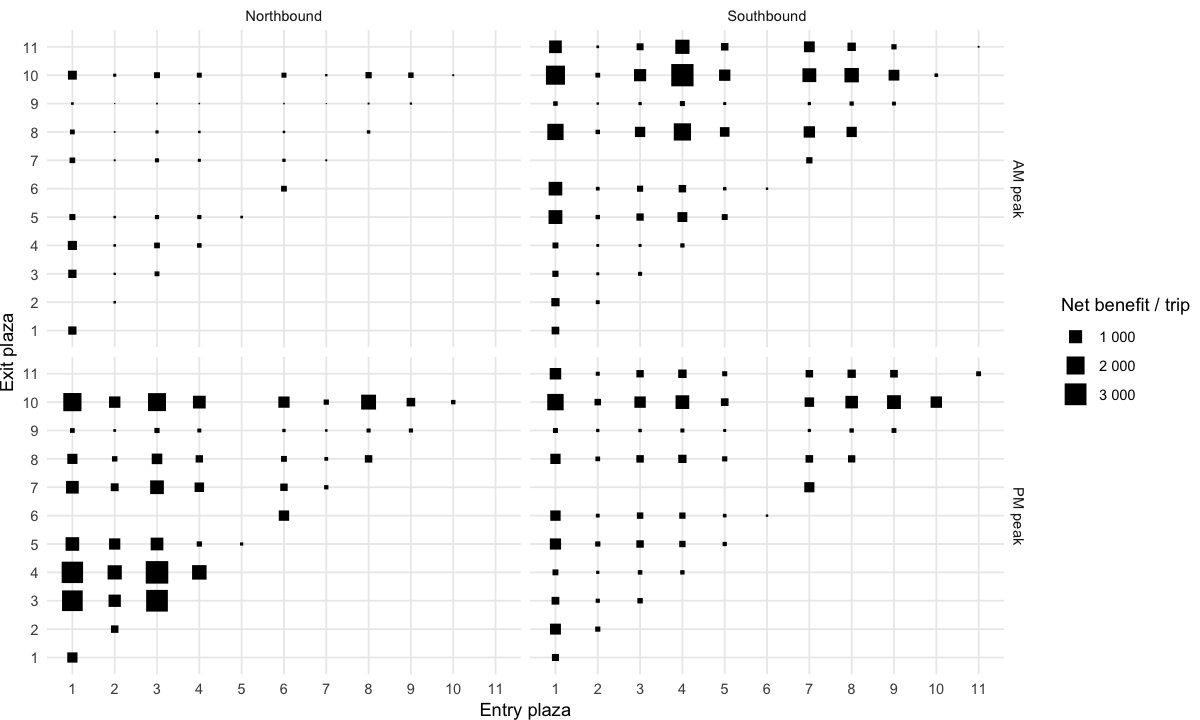

In [149]:
ggplot(route_benefits, aes(as_factor(entry), as_factor(exit),  size=trips)) +
    #facet_wrap("direction") +
    facet_grid(peak_group ~ direction) +
    geom_point(shape=15) + 
    scale_size_continuous(labels=scales::number, range=c(0, 6)) +
    guides(color=guide_legend(override.aes=list(size=7))) +
    labs(size="Net benefit / trip", color="", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))


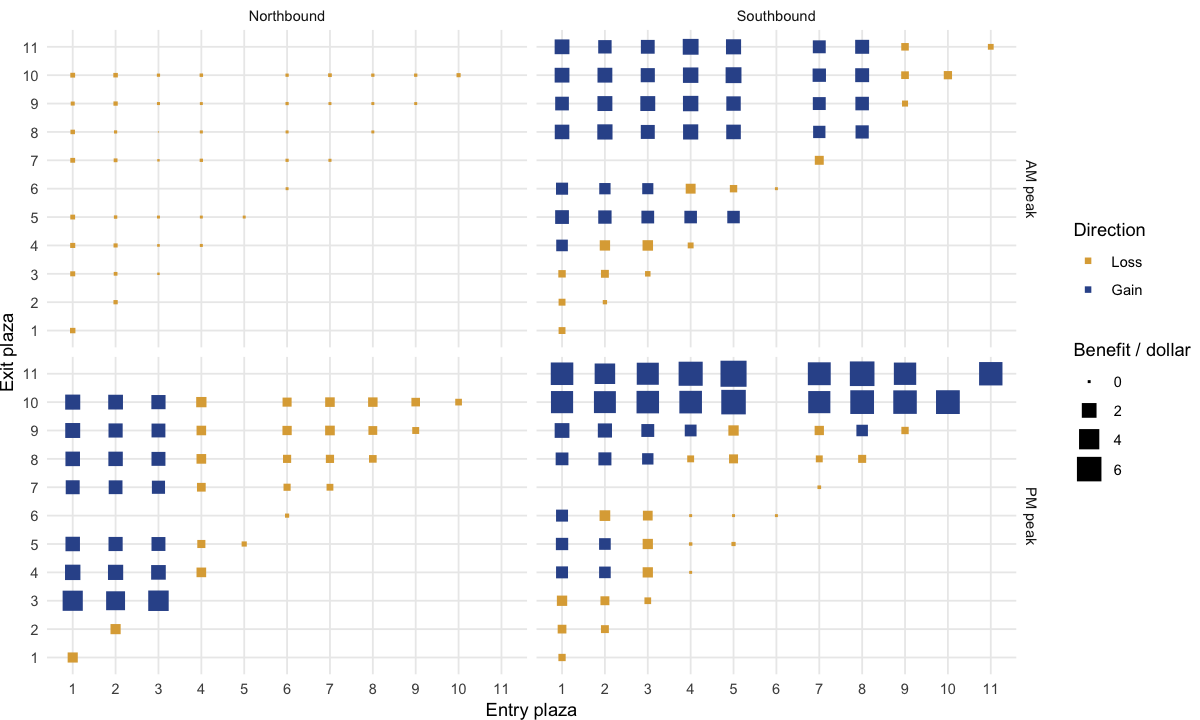

In [141]:
ggplot(route_benefits, aes(as_factor(entry), as_factor(exit), color=(total_benefit/revenue > 1), size=total_benefit/revenue)) +
    #facet_wrap("direction") +
    facet_grid(peak_group ~ direction) +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#ddaa44", "#335599"), labels=c("Loss", "Gain")) +
    scale_size_continuous(labels=scales::number, range=c(0, 7)) +
    #guides(color=F) +
    labs(size="Benefit / dollar", color="Direction", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

## Horizontal equity: Elasticity by County

In [55]:
benefits.d = fips_benefits %>%
    ungroup() %>%
    filter(is_hov==0, net_benefit > 0, trips > 0) %>%
    mutate(y = log(net_benefit / trips),
           x = log(mean_inc/1e6)) %>%
    select(fips, tract, x, y, county) 

m = suppressMessages(suppressWarnings(
        lmer(y ~ x + (x|county) + (1|tract), data=benefits.d, 
             control=lmerControl(check.nobs.vs.nRE="ignore", 
                                 optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
    ))

In [56]:
table(benefits.d$county)


     King    Kitsap  Kittitas    Pierce    Skagit Snohomish  Thurston   Whatcom 
     1211        19        10       228        60       466         9        72 
   Yakima 
        7 

In [57]:
summary(m)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + (x | county) + (1 | tract)
   Data: benefits.d
Control: 
lmerControl(check.nobs.vs.nRE = "ignore", optCtrl = list(ftol_abs = 0.000000001,  
    xtol_abs = 0.000000001))

REML criterion at convergence: 5099

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5983 -0.3426  0.1486  0.5407  2.5975 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 tract    (Intercept) 0.012941 0.11376      
 county   (Intercept) 0.166761 0.40836      
          x           0.009463 0.09728  1.00
 Residual             0.658994 0.81178      
Number of obs: 2082, groups:  tract, 736; county, 9

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.58976    0.20967   2.813
x           -0.04149    0.06422  -0.646

Correlation of Fixed Effects:
  (Intr)
x 0.962 
convergence code: 0
boundary (singular) fit: see ?isSingular


In [58]:
coef(m)$county

,(Intercept),x
,<dbl>,<dbl>
King,0.03326291,-0.174056480
Kitsap,0.63652341,-0.030350447
Kittitas,0.60490894,-0.037881504
Pierce,0.14299564,-0.147916437
Skagit,1.01811910,0.060551581
Snohomish,0.76985190,0.001410473
Thurston,0.57054083,-0.046068523
Whatcom,0.75283164,-0.002644018
Yakima,0.77882214,0.003547324


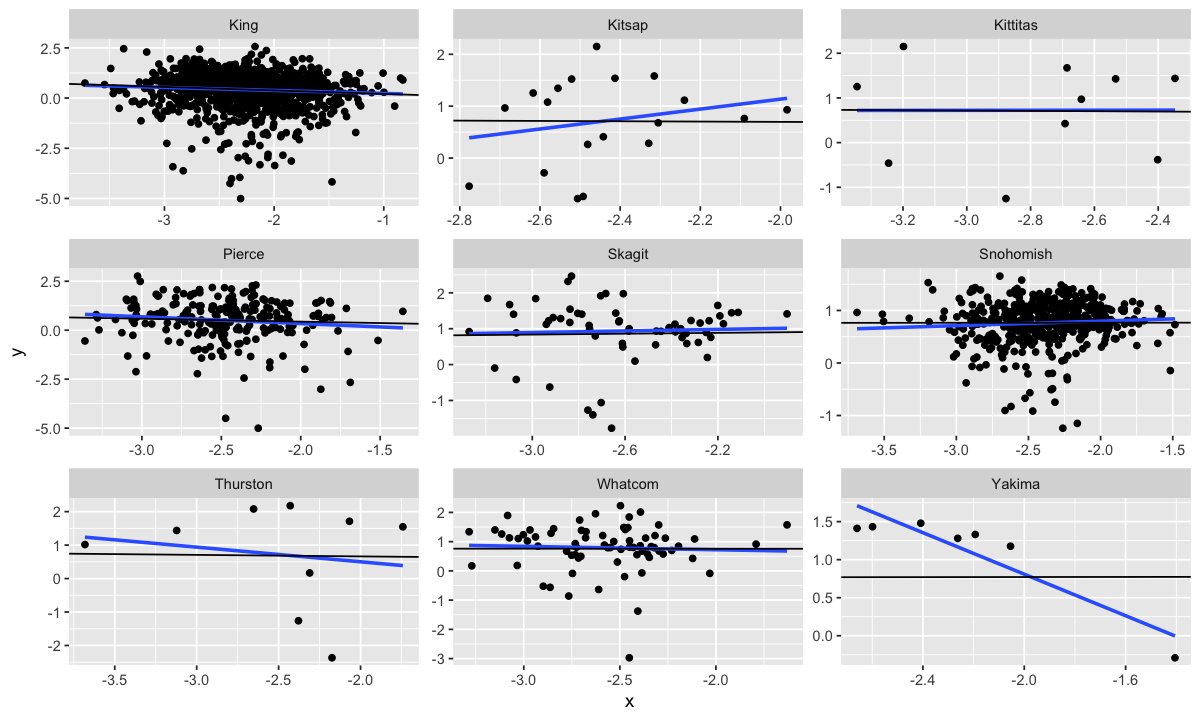

In [62]:
ggplot(benefits.d, aes(x, y)) + 
    facet_wrap("county", scales="free") +
    geom_point() + 
    geom_smooth(method=lm, se=F) +
    geom_abline(aes(slope=x, intercept=`(Intercept)`), data=rownames_to_column(coef(m)$county, "county"))

In [162]:
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2605029,139.2,5087668,271.8,NA,3997904,213.6
Vcells,18337559,140.0,38011157,290.1,16384,38011157,290.1


# *Ignore Everything Below Here*

In [202]:
test.d = trips.2pct %>% 
    filter(is_hov==0) %>%
    mutate(infl_factor = case_when(
               freq == "1_single" ~ 0.6,
               freq == "2_monthly" ~ 0.75,
               freq == "3_weekly" ~ 1.0,
               freq == "4_regular" ~ 1.1,
               freq == "5_daily" ~ 1.3,
               T ~ NA_real_),
           infl_factor_2 =  1.1 - (toll-0.75)/20,
           #inc = rnorm(n(), med_inc * infl_factor, 4e3+0.05*med_inc),
           inc = med_inc * (0.5*infl_factor + 0.5*infl_factor_2),
           #inc = med_inc * infl_factor_2,
           savings_benefit = VOT*savings,
           reliability_benefit = VOR*reliability,
           total_benefit = VOT*savings + VOR*reliability,
           net_benefit = total_benefit - toll) %>%
    drop_na(inc)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10519 rows containing non-finite values (stat_bin).”

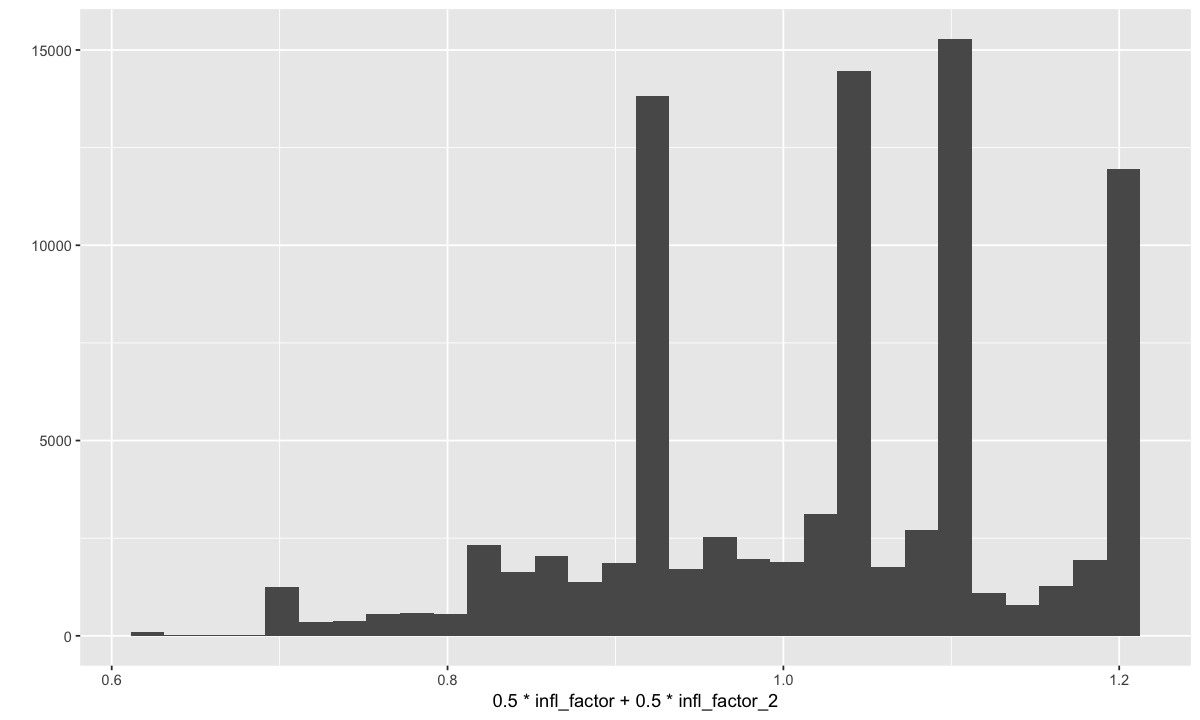

In [198]:
with(test.d, qplot(0.5*infl_factor + 0.5*infl_factor_2))

In [187]:
head(test.d)

trip_id,def_id,toll,entry_time,exit_time,entry_plaza,exit_plaza,is_hov,tag_id,id,⋯,med_inc,race_nonhisp_asian,race_nonhisp_white,infl_factor,infl_factor_2,inc,savings_benefit,reliability_benefit,total_benefit,net_benefit
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
104024189,2706,0.75,1514880965,1514881452,16,23,0,-2579695942875726336,6765682015448136704,⋯,90840,0.34859675,0.5795175,1.10,1.1000,99924.00,1.9008412,1.1040067,3.0048479,2.254848
104024193,2705,0.75,1514878538,1514878585,16,17,0,-1807528794687702784,-9189267815259293696,⋯,92333,0.35751295,0.5122132,1.10,1.1000,101566.30,0.9297593,0.5361687,1.4659280,0.715928
104024595,2694,0.75,1514906339,1514906990,5,12,0,4768809296734673920,-79136306211544352,⋯,91313,0.23516836,0.6664885,1.30,1.1000,109575.60,1.2780500,1.4072955,2.6853456,1.935346
104024773,2714,5.00,1514881034,1514881125,13,14,0,-5001955610155659264,7259006965466960896,⋯,79038,0.20654297,0.5708008,1.30,0.8875,86447.81,0.0000000,-0.9254065,-0.9254065,-5.925407
104024830,2706,0.75,1514880361,1514880893,16,22,0,-1245532173087846144,-3193509462675307008,⋯,62099,0.09844789,0.7188470,1.30,1.1000,74518.80,3.4681497,1.1254387,4.5935884,3.843588
104025124,2715,2.50,1514884692,1514885690,13,23,0,6501930112689869824,7889107484313163776,⋯,26531,0.00000000,0.6680097,0.75,1.0125,23380.44,0.0354194,3.5421013,3.5775207,1.077521


In [208]:
#lmer(net_benefit ~ log(inc) + (1|fips), data=filter(test.d))
lmer(net_benefit ~ log(inc) + (1|entry_plaza) + (1|exit_plaza), data=filter(test.d))

Linear mixed model fit by REML ['lmerMod']
Formula: net_benefit ~ log(inc) + (1 | entry_plaza) + (1 | exit_plaza)
   Data: filter(test.d)
REML criterion at convergence: 483438.9
Random effects:
 Groups      Name        Std.Dev.
 exit_plaza  (Intercept) 2.184   
 entry_plaza (Intercept) 1.816   
 Residual                3.614   
Number of obs: 89354, groups:  exit_plaza, 21; entry_plaza, 20
Fixed Effects:
(Intercept)     log(inc)  
     1.3432      -0.1676  

In [ ]:
test.fips = 

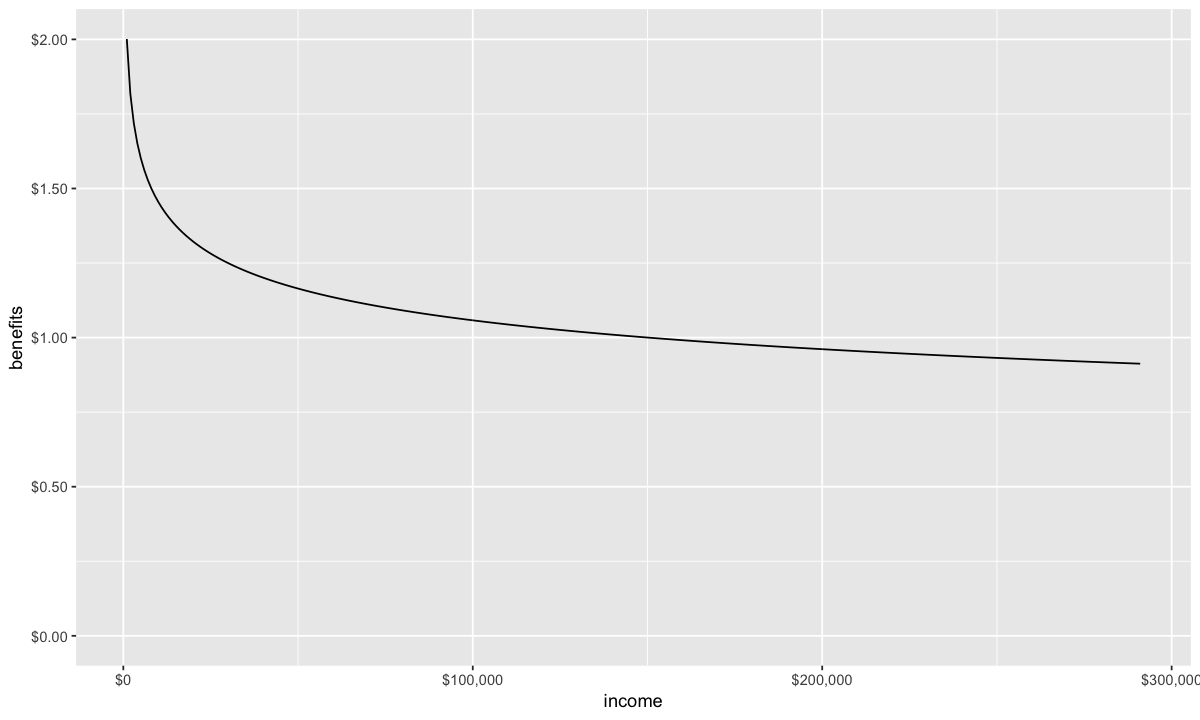

In [738]:
mcoef = coef(summary(sov.benefits.m))[,1]
se.coef = coef(summary(sov.benefits.m))[,2]
x = seq(10:300)
y = exp(mcoef[1] + mcoef[2]*log(x))

tibble(income=1e3*x, benefits=y) %>%
ggplot(aes(income, benefits)) +
    geom_line() +
    scale_y_continuous(labels=scales::dollar, limits=c(0, NA)) +
    scale_x_continuous(labels=scales::dollar)

In [ ]:
N = 5e3
incomes = rdagum(N, b, a, p)/1e3
hh_benefits = exp(predict(sov.hh_benefits.m, newdata=tibble(hh_income=incomes, tract="all"), allow.new.levels=T))
trip_benefits = exp(predict(sov.trip_benefits.m, newdata=tibble(hh_income=incomes, tract="all"), allow.new.levels=T))
fare_benefits = exp(predict(sov.fare_benefits.m, newdata=tibble(hh_income=incomes, tract="all"), allow.new.levels=T))
hh_fares = exp(predict(sov.hh_fares.m, newdata=tibble(hh_income=incomes, tract="all"), allow.new.levels=T))
trip_fares = exp(predict(sov.trip_fares.m, newdata=tibble(hh_income=incomes, tract="all"), allow.new.levels=T))
hh_trips = exp(predict(sov.hh_trips.m, newdata=tibble(hh_income=incomes, tract="all"), allow.new.levels=T))
#hh_trips = exp(1.834+(-0.5)*log(incomes))

suits.d = tibble(income=incomes, hh_benefits, trip_benefits, 
                 hh_fares, trip_fares, hh_trips) %>%
    arrange(income) %>%
    mutate(cuml_inc = cumsum(income)/sum(income),
           inc_quantile = (row_number()-0.5)/length(income),
           cuml_hh_benefits = cumsum(hh_benefits)/sum(hh_benefits),
           cuml_hh_fares = cumsum(hh_fares)/sum(hh_fares),
           cuml_hh_trips = cumsum(hh_trips)/sum(hh_trips),
           cuml_trip_benefits = cumsum(trip_benefits)/sum(trip_benefits),
           cuml_trip_fares = cumsum(trip_fares)/sum(trip_fares),
           cuml_fare_benefits = cumsum(fare_benefits)/sum(fare_benefits))

In [ ]:
figure.d = suits.d %>%
    select(starts_with("cuml"), x=inc_quantile) %>%
    select(-contains("cuml_inc")) %>%
    gather(type, y, -x)
suits = figure.d %>%
    group_by(type) %>%
    summarize(suits=mean(y - x)*if_else(str_detect(type[1], "fares"), -1, 1),
              y=0.25+mean(y[x>0.48 & x<0.52])/2, x=0.5)

ggplot(figure.d, aes(x, y, ymax=y, ymin=x)) + 
    facet_wrap("type") +
    geom_line() + 
    geom_abline(slope=1, lty="dashed") + 
    geom_ribbon(alpha=0.2) +
    coord_fixed() +
    geom_text(aes(label=round(suits, 2)), data=suits, angle=45, size=3, fontface="bold") + 
    labs(x="Income Quantile")

In [ ]:
figure.d = suits.d %>%
    select(starts_with("cuml"), x=cuml_inc) %>%
    select(-contains("cuml_inc")) %>%
    gather(type, y, -x)
suits = figure.d %>%
    group_by(type) %>%
    summarize(suits=mean(y - x)*if_else(str_detect(type[1], "fares"), -1, 1),
              y=0.25+mean(y[x>0.48 & x<0.52])/2, x=0.5)

ggplot(figure.d, aes(x, y, ymax=y, ymin=x)) + 
    facet_wrap("type") +
    geom_line() + 
    geom_abline(slope=1, lty="dashed") + 
    geom_ribbon(alpha=0.2) +
    coord_fixed() +
    geom_text(aes(label=round(suits, 2)), data=suits, angle=45, size=3, fontface="bold") + 
    labs(x="Cumulative Share of Income")

In [740]:
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,3116333,166.5,5444742,290.8,NA,5444742,290.8
Vcells,13879237,105.9,35415122,270.2,16384,35260750,269.1
